In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import umap
import pandas as pd
from sklearn.decomposition import PCA

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_start = 1
pred_end = 2

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
train_mod1_X = input_train_mod1.X.toarray()
train_mod1_X.shape

(66175, 13953)

In [9]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [10]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [11]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [12]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [13]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [14]:
batch_total = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)+list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)+list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [15]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [16]:
pro_s1d1 = pro_s1d1.X.toarray()[:, pred_start:pred_end]
pro_s1d2 = pro_s1d2.X.toarray()[:, pred_start:pred_end]
pro_s1d3 = pro_s1d3.X.toarray()[:, pred_start:pred_end]
pro_s2d1 = pro_s2d1.X.toarray()[:, pred_start:pred_end]
pro_s2d4 = pro_s2d4.X.toarray()[:, pred_start:pred_end]
pro_s2d5 = pro_s2d5.X.toarray()[:, pred_start:pred_end]

pro_s3d1 = pro_s3d1.X.toarray()[:, pred_start:pred_end]
pro_s3d6 = pro_s3d6.X.toarray()[:, pred_start:pred_end]
pro_s3d7 = pro_s3d7.X.toarray()[:, pred_start:pred_end]

In [17]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [18]:
pro_s4d1 = pro_s4d1.X.toarray()[:, pred_start:pred_end]
pro_s4d8 = pro_s4d8.X.toarray()[:, pred_start:pred_end]
pro_s4d9 = pro_s4d9.X.toarray()[:, pred_start:pred_end]

In [19]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 1)


In [20]:
RNA_total = np.concatenate([RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5, RNA_s3d1, RNA_s3d6, RNA_s3d7, RNA_s4d1, RNA_s4d8, RNA_s4d9], axis=0)

In [21]:
pca = PCA(n_components=800)
RNA_total_pca = pca.fit_transform(RNA_total)

In [22]:
RNA_total_pca_pd = pd.DataFrame(RNA_total_pca)
RNA_total_pca_pd['batch'] = batch_total

In [23]:
RNA_s1d1 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s1d1'].iloc[:, :-1].to_numpy()
RNA_s1d2 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s1d2'].iloc[:, :-1].to_numpy()
RNA_s1d3 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s1d3'].iloc[:, :-1].to_numpy()
RNA_s2d1 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s2d1'].iloc[:, :-1].to_numpy()
RNA_s2d4 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s2d4'].iloc[:, :-1].to_numpy()
RNA_s2d5 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s2d5'].iloc[:, :-1].to_numpy()

RNA_s3d1 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s3d1'].iloc[:, :-1].to_numpy()
RNA_s3d6 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s3d6'].iloc[:, :-1].to_numpy()
RNA_s3d7 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s3d7'].iloc[:, :-1].to_numpy()

RNA_s4d1 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s4d1'].iloc[:, :-1].to_numpy()
RNA_s4d8 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s4d8'].iloc[:, :-1].to_numpy()
RNA_s4d9 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s4d9'].iloc[:, :-1].to_numpy()

In [24]:
# batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
# batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
# batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [25]:
RNA_s1d1 = torch.from_numpy(RNA_s1d1)
RNA_s1d2 = torch.from_numpy(RNA_s1d2)
RNA_s1d3 = torch.from_numpy(RNA_s1d3)
RNA_s2d1 = torch.from_numpy(RNA_s2d1)
RNA_s2d4 = torch.from_numpy(RNA_s2d4)
RNA_s2d5 = torch.from_numpy(RNA_s2d5)
RNA_s3d1 = torch.from_numpy(RNA_s3d1)
RNA_s3d6 = torch.from_numpy(RNA_s3d6)
RNA_s3d7 = torch.from_numpy(RNA_s3d7)
RNA_s4d1 = torch.from_numpy(RNA_s4d1)
RNA_s4d8 = torch.from_numpy(RNA_s4d8)
RNA_s4d9 = torch.from_numpy(RNA_s4d9)

In [26]:
pro_s1d1 = torch.from_numpy(pro_s1d1)
pro_s1d2 = torch.from_numpy(pro_s1d2)
pro_s1d3 = torch.from_numpy(pro_s1d3)
pro_s2d1 = torch.from_numpy(pro_s2d1)
pro_s2d4 = torch.from_numpy(pro_s2d4)
pro_s2d5 = torch.from_numpy(pro_s2d5)
pro_s3d1 = torch.from_numpy(pro_s3d1)
pro_s3d6 = torch.from_numpy(pro_s3d6)
pro_s3d7 = torch.from_numpy(pro_s3d7)
pro_s4d1 = torch.from_numpy(pro_s4d1)
pro_s4d8 = torch.from_numpy(pro_s4d8)
pro_s4d9 = torch.from_numpy(pro_s4d9)

In [27]:
RNA_s1d1 = RNA_s1d1.float()
RNA_s1d2 = RNA_s1d2.float()
RNA_s1d3 = RNA_s1d3.float()
RNA_s2d1 = RNA_s2d1.float()
RNA_s2d4 = RNA_s2d4.float()
RNA_s2d5 = RNA_s2d5.float()
RNA_s3d1 = RNA_s3d1.float()
RNA_s3d6 = RNA_s3d6.float()
RNA_s3d7 = RNA_s3d7.float()
RNA_s4d1 = RNA_s4d1.float()
RNA_s4d8 = RNA_s4d8.float()
RNA_s4d9 = RNA_s4d9.float()

pro_s1d1 = pro_s1d1.float()
pro_s1d2 = pro_s1d2.float()
pro_s1d3 = pro_s1d3.float()
pro_s2d1 = pro_s2d1.float()
pro_s2d4 = pro_s2d4.float()
pro_s2d5 = pro_s2d5.float()
pro_s3d1 = pro_s3d1.float()
pro_s3d6 = pro_s3d6.float()
pro_s3d7 = pro_s3d7.float()
pro_s4d1 = pro_s4d1.float()
pro_s4d8 = pro_s4d8.float()
pro_s4d9 = pro_s4d9.float()

In [28]:
RNA_s1d1 = RNA_s1d1.to(device)
RNA_s1d2 = RNA_s1d2.to(device)
RNA_s1d3 = RNA_s1d3.to(device)
RNA_s2d1 = RNA_s2d1.to(device)
RNA_s2d4 = RNA_s2d4.to(device)
RNA_s2d5 = RNA_s2d5.to(device)
RNA_s3d1 = RNA_s3d1.to(device)
RNA_s3d6 = RNA_s3d6.to(device)
RNA_s3d7 = RNA_s3d7.to(device)
RNA_s4d1 = RNA_s4d1.to(device)
RNA_s4d8 = RNA_s4d8.to(device)
RNA_s4d9 = RNA_s4d9.to(device)

pro_s1d1 = pro_s1d1.to(device)
pro_s1d2 = pro_s1d2.to(device)
pro_s1d3 = pro_s1d3.to(device)
pro_s2d1 = pro_s2d1.to(device)
pro_s2d4 = pro_s2d4.to(device)
pro_s2d5 = pro_s2d5.to(device)
pro_s3d1 = pro_s3d1.to(device)
pro_s3d6 = pro_s3d6.to(device)
pro_s3d7 = pro_s3d7.to(device)
pro_s4d1 = pro_s4d1.to(device)
pro_s4d8 = pro_s4d8.to(device)
pro_s4d9 = pro_s4d9.to(device)

In [29]:
input_feature = RNA_s1d1.shape[1]
# output_feature = pred_num

In [30]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, 1)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [31]:
PATH = 'No_norm_model_RNA_pro'

In [32]:
# def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output):
def fit(num_epochs, model, loss_fn, RNA, pro):
    
    train_ds = TensorDataset(RNA, pro)
    train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            # print(y.shape, pred.shape)
            # y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

# train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
# train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

# val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
# val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

# test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
# test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

        if epoch % 100 == 0:
            model = model.eval()
            
            s1d1_pred = model(RNA_s1d1)
            s1d1_loss = loss_fn(s1d1_pred, pro_s1d1)
            s1d1_loss = torch.sqrt(s1d1_loss)
            s1d1_loss = s1d1_loss.cpu().detach().numpy()
            
            s1d2_pred = model(RNA_s1d2)
            s1d2_loss = loss_fn(s1d2_pred, pro_s1d2)
            s1d2_loss = torch.sqrt(s1d2_loss)
            s1d2_loss = s1d2_loss.cpu().detach().numpy()
            
            s1d3_pred = model(RNA_s1d3)
            s1d3_loss = loss_fn(s1d3_pred, pro_s1d3)
            s1d3_loss = torch.sqrt(s1d3_loss)
            s1d3_loss = s1d3_loss.cpu().detach().numpy()
            
            s2d1_pred = model(RNA_s2d1)
            s2d1_loss = loss_fn(s2d1_pred, pro_s2d1)
            s2d1_loss = torch.sqrt(s2d1_loss)
            s2d1_loss = s2d1_loss.cpu().detach().numpy()
            
            s2d4_pred = model(RNA_s2d4)
            s2d4_loss = loss_fn(s2d4_pred, pro_s2d4)
            s2d4_loss = torch.sqrt(s2d4_loss)
            s2d4_loss = s2d4_loss.cpu().detach().numpy()
            
            s2d5_pred = model(RNA_s2d5)
            s2d5_loss = loss_fn(s2d5_pred, pro_s2d5)
            s2d5_loss = torch.sqrt(s2d5_loss)
            s2d5_loss = s2d5_loss.cpu().detach().numpy()
            
            s3d1_pred = model(RNA_s3d1)
            s3d1_loss = loss_fn(s3d1_pred, pro_s3d1)
            s3d1_loss = torch.sqrt(s3d1_loss)
            s3d1_loss = s3d1_loss.cpu().detach().numpy()
            
            s3d6_pred = model(RNA_s3d6)
            s3d6_loss = loss_fn(s3d6_pred, pro_s3d6)
            s3d6_loss = torch.sqrt(s3d6_loss)
            s3d6_loss = s3d6_loss.cpu().detach().numpy()
            
            s3d7_pred = model(RNA_s3d7)
            s3d7_loss = loss_fn(s3d7_pred, pro_s3d7)
            s3d7_loss = torch.sqrt(s3d7_loss)
            s3d7_loss = s3d7_loss.cpu().detach().numpy()

            s4d1_pred = model(RNA_s4d1)
            s4d1_loss = loss_fn(s4d1_pred, pro_s4d1)
            s4d1_loss = torch.sqrt(s4d1_loss)
            s4d1_loss = s4d1_loss.cpu().detach().numpy()
            
            s4d8_pred = model(RNA_s4d8)
            s4d8_loss = loss_fn(s4d8_pred, pro_s4d8)
            s4d8_loss = torch.sqrt(s4d8_loss)
            s4d8_loss = s4d8_loss.cpu().detach().numpy()
            
            s4d9_pred = model(RNA_s4d9)
            s4d9_loss = loss_fn(s4d9_pred, pro_s4d9)
            s4d9_loss = torch.sqrt(s4d9_loss)
            s4d9_loss = s4d9_loss.cpu().detach().numpy()
            
#             if val_loss < val_best:
#                 torch.save(model.state_dict(), PATH)
#                 val_best = val_loss
            test_loss = ((s4d1_loss**2*s4d1_pred.shape[0] + s4d8_loss**2*s4d8_pred.shape[0] + s4d9_loss**2*s4d9_pred.shape[0])/(s4d1_pred.shape[0]+s4d8_pred.shape[0]+s4d9_pred.shape[0]))**0.5
            print('Epoch ', epoch, 's1d1: ', s1d1_loss, 's1d2: ', s1d2_loss, 's1d3: ', s1d3_loss, 's2d1:', s2d1_loss, 's2d4:', s2d4_loss, 's2d5:', s2d5_loss, 's3d1:', s3d1_loss, 's3d6:', s3d6_loss, 's3d7:', s3d7_loss, 's4d1:', s4d1_loss, 's4d8:', s4d8_loss, 's4d9:', s4d9_loss, 'test loss:', test_loss)
            
        if epoch % 1000 == 0:
            figure, ax = plt.subplots(1, 12, figsize = (30, 3))
            for i in range(1):
                ax[0].scatter(pro_s1d1.cpu().detach().numpy()[:, 0], s1d1_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('s1d1 result')
                ax[0].set_xlabel('true')
                ax[0].set_ylabel('pred')

                ax[1].scatter(pro_s1d2.cpu().detach().numpy()[:, 0], s1d2_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('s1d2 result')
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(pro_s1d3.cpu().detach().numpy()[:, 0], s1d3_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('s1d3 result')
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
                
                ax[3].scatter(pro_s2d1.cpu().detach().numpy()[:, 0], s2d1_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[3].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[3].set_title('s2d1 result')
                ax[3].set_xlabel('true')
                ax[3].set_ylabel('pred')

                ax[4].scatter(pro_s2d4.cpu().detach().numpy()[:, 0], s2d4_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[4].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[4].set_title('s2d4 result')
                ax[4].set_xlabel('true')
                ax[4].set_ylabel('pred')

                ax[5].scatter(pro_s2d5.cpu().detach().numpy()[:, 0], s2d5_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[5].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[5].set_title('s2d5 result')
                ax[5].set_xlabel('true')
                ax[5].set_ylabel('pred')
                
                ax[6].scatter(pro_s3d1.cpu().detach().numpy()[:, 0], s3d1_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[6].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[6].set_title('s3d1 result')
                ax[6].set_xlabel('true')
                ax[6].set_ylabel('pred')

                ax[7].scatter(pro_s3d6.cpu().detach().numpy()[:, 0], s3d6_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[7].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[7].set_title('s3d6 result')
                ax[7].set_xlabel('true')
                ax[7].set_ylabel('pred')

                ax[8].scatter(pro_s3d7.cpu().detach().numpy()[:, 0], s3d7_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[8].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[8].set_title('s3d7 result')
                ax[8].set_xlabel('true')
                ax[8].set_ylabel('pred')
                
                ax[9].scatter(pro_s4d1.cpu().detach().numpy()[:, 0], s4d1_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[9].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[9].set_title('s4d1 result')
                ax[9].set_xlabel('true')
                ax[9].set_ylabel('pred')

                ax[10].scatter(pro_s4d8.cpu().detach().numpy()[:, 0], s4d8_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[10].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[10].set_title('s4d8 result')
                ax[10].set_xlabel('true')
                ax[10].set_ylabel('pred')

                ax[11].scatter(pro_s4d9.cpu().detach().numpy()[:, 0], s4d9_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[11].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[11].set_title('s4d9 result')
                ax[11].set_xlabel('true')
                ax[11].set_ylabel('pred')
            
            plt.show()
    return

Epoch  0 s1d1:  0.30034184 s1d2:  0.30944556 s1d3:  0.28607923 s2d1: 1.1466005 s2d4: 0.94776756 s2d5: 0.435062 s3d1: 0.5016835 s3d6: 0.50897974 s3d7: 0.38324633 s4d1: 0.56093985 s4d8: 0.53068584 s4d9: 1.3187704 test loss: 0.9806444288520901


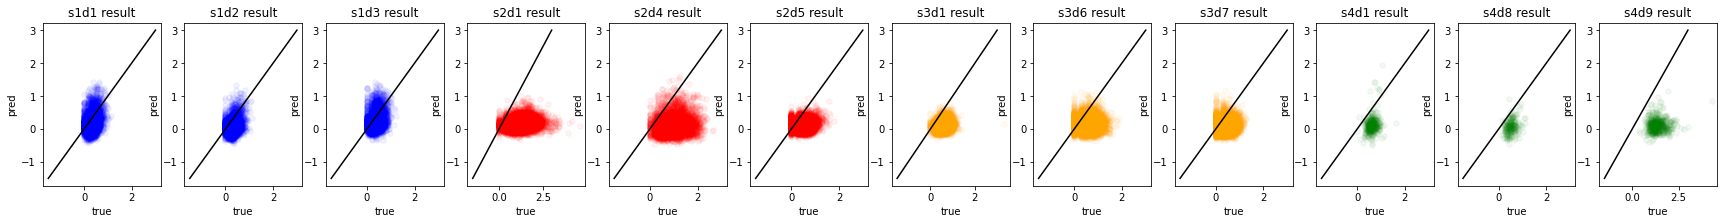

Epoch  100 s1d1:  0.18383092 s1d2:  0.19536445 s1d3:  0.20926291 s2d1: 1.1266546 s2d4: 0.7978391 s2d5: 0.3859201 s3d1: 0.55175555 s3d6: 0.44482908 s3d7: 0.29803172 s4d1: 0.38834614 s4d8: 0.33341083 s4d9: 1.1558523 test loss: 0.8286155107745791
Epoch  200 s1d1:  0.17509468 s1d2:  0.18874453 s1d3:  0.2030783 s2d1: 1.1218216 s2d4: 0.7944227 s2d5: 0.38040268 s3d1: 0.54385585 s3d6: 0.43899846 s3d7: 0.29298657 s4d1: 0.38334724 s4d8: 0.33104464 s4d9: 1.1543509 test loss: 0.8266786971246491
Epoch  300 s1d1:  0.17058186 s1d2:  0.18495424 s1d3:  0.2002733 s2d1: 1.119734 s2d4: 0.79387945 s2d5: 0.37807918 s3d1: 0.5401711 s3d6: 0.43679264 s3d7: 0.2908579 s4d1: 0.38124776 s4d8: 0.33023456 s4d9: 1.1534288 test loss: 0.8256959944774565
Epoch  400 s1d1:  0.16762732 s1d2:  0.18246362 s1d3:  0.19870843 s2d1: 1.1184133 s2d4: 0.7941251 s2d5: 0.3761885 s3d1: 0.5343628 s3d6: 0.43568406 s3d7: 0.28943843 s4d1: 0.38028306 s4d8: 0.32998708 s4d9: 1.1531765 test loss: 0.8253651336636714
Epoch  500 s1d1:  0.1654411

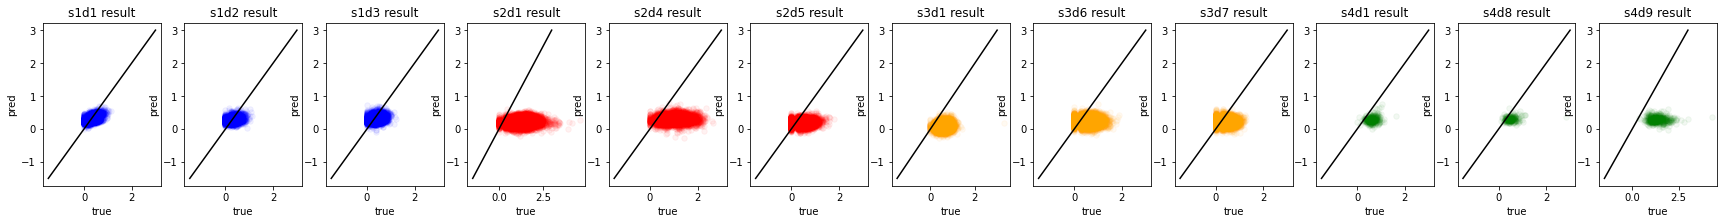

Epoch  1100 s1d1:  0.15788478 s1d2:  0.17628378 s1d3:  0.19473416 s2d1: 1.1120758 s2d4: 0.7946104 s2d5: 0.3693543 s3d1: 0.5200877 s3d6: 0.43261912 s3d7: 0.28564024 s4d1: 0.37770033 s4d8: 0.32973155 s4d9: 1.1511638 test loss: 0.8236564967527084
Epoch  1200 s1d1:  0.15699622 s1d2:  0.17595942 s1d3:  0.19456536 s2d1: 1.1112976 s2d4: 0.79467404 s2d5: 0.36860213 s3d1: 0.5186876 s3d6: 0.43233615 s3d7: 0.28539756 s4d1: 0.37761033 s4d8: 0.32973164 s4d9: 1.1509856 test loss: 0.8235283819205192
Epoch  1300 s1d1:  0.15615031 s1d2:  0.17572765 s1d3:  0.19444643 s2d1: 1.110664 s2d4: 0.7946171 s2d5: 0.3678633 s3d1: 0.51757014 s3d6: 0.4320343 s3d7: 0.2851506 s4d1: 0.37760022 s4d8: 0.3298484 s4d9: 1.1509689 test loss: 0.8235258169378575
Epoch  1400 s1d1:  0.15533507 s1d2:  0.17559996 s1d3:  0.1944639 s2d1: 1.1104385 s2d4: 0.7949875 s2d5: 0.36740917 s3d1: 0.51749784 s3d6: 0.43198556 s3d7: 0.2850717 s4d1: 0.37781924 s4d8: 0.33011064 s4d9: 1.1511161 test loss: 0.8236755520978157
Epoch  1500 s1d1:  0.1545

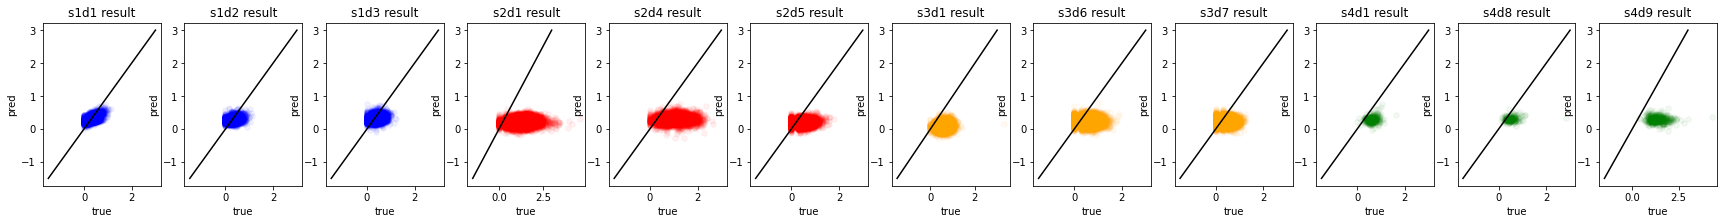

Epoch  2100 s1d1:  0.14985085 s1d2:  0.17537147 s1d3:  0.19474727 s2d1: 1.11113 s2d4: 0.7951984 s2d5: 0.36620414 s3d1: 0.52437437 s3d6: 0.4324254 s3d7: 0.28546306 s4d1: 0.37734058 s4d8: 0.33010384 s4d9: 1.1496608 test loss: 0.8226681390403158
Epoch  2200 s1d1:  0.14907908 s1d2:  0.17542796 s1d3:  0.19486089 s2d1: 1.1114355 s2d4: 0.7952292 s2d5: 0.36621678 s3d1: 0.5257879 s3d6: 0.43255273 s3d7: 0.2856109 s4d1: 0.37729686 s4d8: 0.3300346 s4d9: 1.1493893 test loss: 0.8224815100608713
Epoch  2300 s1d1:  0.14831562 s1d2:  0.17555231 s1d3:  0.19503121 s2d1: 1.1116321 s2d4: 0.7953553 s2d5: 0.3661375 s3d1: 0.52667105 s3d6: 0.43264255 s3d7: 0.28573024 s4d1: 0.37740204 s4d8: 0.3300974 s4d9: 1.1492952 test loss: 0.8224425033056159
Epoch  2400 s1d1:  0.14755157 s1d2:  0.17565805 s1d3:  0.19517033 s2d1: 1.111967 s2d4: 0.79539466 s2d5: 0.3661555 s3d1: 0.5280548 s3d6: 0.43273407 s3d7: 0.285873 s4d1: 0.37735903 s4d8: 0.33009094 s4d9: 1.1490453 test loss: 0.8222751176018871
Epoch  2500 s1d1:  0.1467861

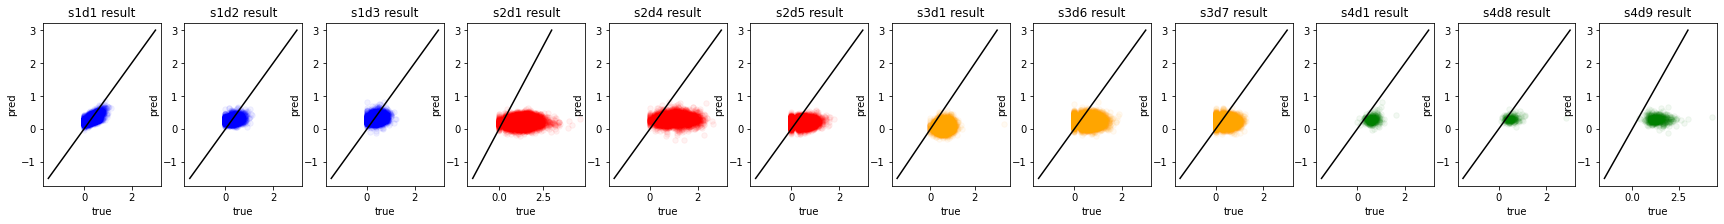

Epoch  3100 s1d1:  0.1422221 s1d2:  0.17667162 s1d3:  0.19643024 s2d1: 1.113892 s2d4: 0.79566646 s2d5: 0.3663554 s3d1: 0.5349801 s3d6: 0.4335127 s3d7: 0.2871538 s4d1: 0.3774252 s4d8: 0.33016527 s4d9: 1.1473546 test loss: 0.8212070847555962
Epoch  3200 s1d1:  0.14146236 s1d2:  0.17685364 s1d3:  0.19663379 s2d1: 1.1143779 s2d4: 0.79562014 s2d5: 0.36665106 s3d1: 0.536524 s3d6: 0.43370876 s3d7: 0.28746974 s4d1: 0.3773561 s4d8: 0.33014518 s4d9: 1.1469579 test loss: 0.820940406819219
Epoch  3300 s1d1:  0.14070775 s1d2:  0.17703107 s1d3:  0.19687375 s2d1: 1.1147596 s2d4: 0.7957948 s2d5: 0.3667119 s3d1: 0.537434 s3d6: 0.4338582 s3d7: 0.28767928 s4d1: 0.3774354 s4d8: 0.33024266 s4d9: 1.1467313 test loss: 0.8208153506091665
Epoch  3400 s1d1:  0.13995767 s1d2:  0.17717962 s1d3:  0.19708131 s2d1: 1.115008 s2d4: 0.7958842 s2d5: 0.36675954 s3d1: 0.53795654 s3d6: 0.4339925 s3d7: 0.28787127 s4d1: 0.37749696 s4d8: 0.3303135 s4d9: 1.1465511 test loss: 0.8207152087362852
Epoch  3500 s1d1:  0.13920264 s1d

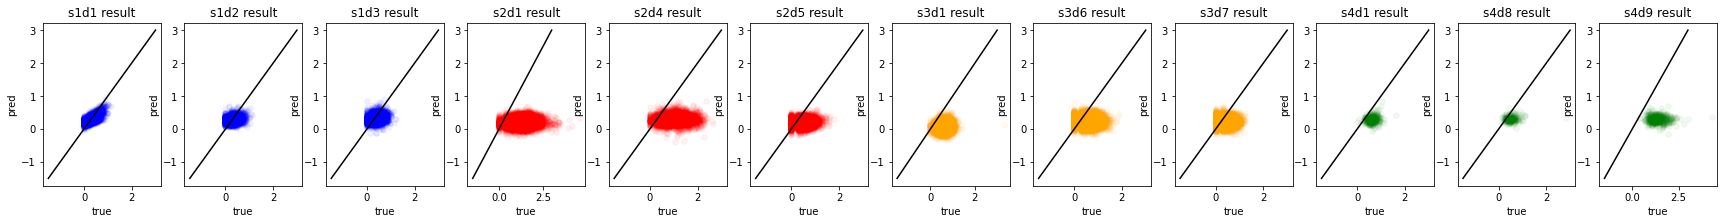

Epoch  4100 s1d1:  0.13475981 s1d2:  0.17854048 s1d3:  0.19858852 s2d1: 1.116661 s2d4: 0.7962577 s2d5: 0.36726707 s3d1: 0.54220104 s3d6: 0.43448 s3d7: 0.2892663 s4d1: 0.37722123 s4d8: 0.3303893 s4d9: 1.1445656 test loss: 0.8194060397252064
Epoch  4200 s1d1:  0.13402112 s1d2:  0.17876057 s1d3:  0.19878782 s2d1: 1.1168947 s2d4: 0.796159 s2d5: 0.36734703 s3d1: 0.54297 s3d6: 0.43460548 s3d7: 0.2894545 s4d1: 0.37712014 s4d8: 0.33035812 s4d9: 1.1442533 test loss: 0.8191876725141504
Epoch  4300 s1d1:  0.13328896 s1d2:  0.17899626 s1d3:  0.19899164 s2d1: 1.1170639 s2d4: 0.7960849 s2d5: 0.3675032 s3d1: 0.54357475 s3d6: 0.43462574 s3d7: 0.2896779 s4d1: 0.37696776 s4d8: 0.33033472 s4d9: 1.1437906 test loss: 0.8188656630199559
Epoch  4400 s1d1:  0.13255283 s1d2:  0.1792294 s1d3:  0.19921824 s2d1: 1.1171947 s2d4: 0.79608166 s2d5: 0.36755058 s3d1: 0.5439337 s3d6: 0.4346643 s3d7: 0.2898722 s4d1: 0.37696114 s4d8: 0.330382 s4d9: 1.1435574 test loss: 0.8187191040091879
Epoch  4500 s1d1:  0.13183025 s1d2

In [33]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s1d1, pro_s1d1)

Epoch  0 s1d1:  0.30010286 s1d2:  0.306112 s1d3:  0.28605247 s2d1: 1.1464719 s2d4: 0.9448977 s2d5: 0.4347985 s3d1: 0.5031047 s3d6: 0.5084381 s3d7: 0.38286665 s4d1: 0.5581111 s4d8: 0.5263943 s4d9: 1.3145952 test loss: 0.9770468450692885


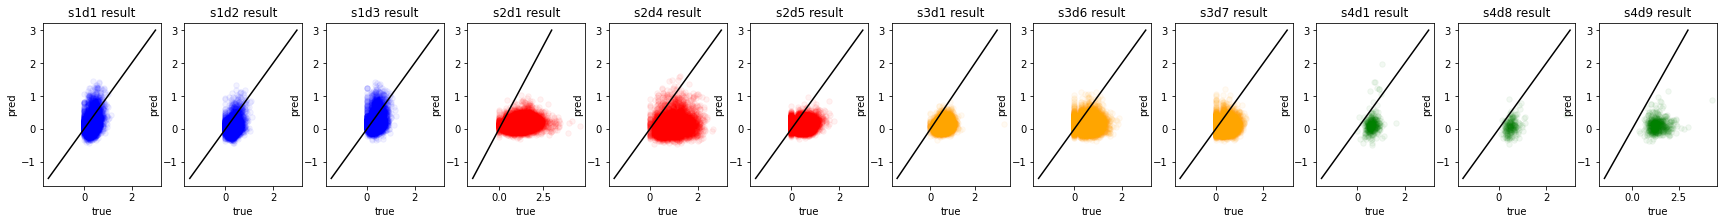

Epoch  100 s1d1:  0.20877445 s1d2:  0.17853253 s1d3:  0.22096312 s2d1: 1.1271327 s2d4: 0.8092377 s2d5: 0.38419455 s3d1: 0.5613074 s3d6: 0.44572294 s3d7: 0.31095234 s4d1: 0.38896486 s4d8: 0.34057504 s4d9: 1.1476663 test loss: 0.8240805004657974
Epoch  200 s1d1:  0.20121673 s1d2:  0.17012292 s1d3:  0.21291181 s2d1: 1.1180879 s2d4: 0.8020341 s2d5: 0.3768535 s3d1: 0.5552135 s3d6: 0.43876043 s3d7: 0.3052961 s4d1: 0.37535945 s4d8: 0.33510917 s4d9: 1.1414592 test loss: 0.8175261699610107
Epoch  300 s1d1:  0.1974803 s1d2:  0.16546245 s1d3:  0.20881592 s2d1: 1.1090266 s2d4: 0.79873025 s2d5: 0.37029487 s3d1: 0.53975594 s3d6: 0.43342066 s3d7: 0.30099025 s4d1: 0.36889508 s4d8: 0.33287263 s4d9: 1.139436 test loss: 0.8150550400378881
Epoch  400 s1d1:  0.19473003 s1d2:  0.16243258 s1d3:  0.20597191 s2d1: 1.1024398 s2d4: 0.79647905 s2d5: 0.36578873 s3d1: 0.5286586 s3d6: 0.42949325 s3d7: 0.29783428 s4d1: 0.36473697 s4d8: 0.33134127 s4d9: 1.1380148 test loss: 0.8133877401505403
Epoch  500 s1d1:  0.19322

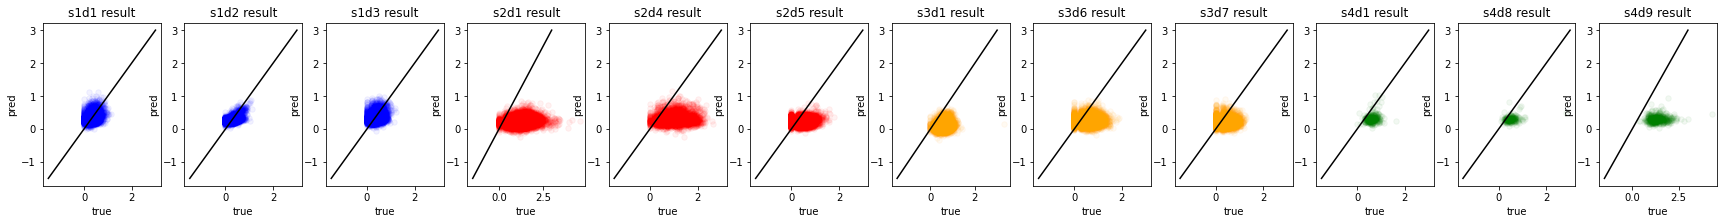

Epoch  1100 s1d1:  0.18945965 s1d2:  0.15256222 s1d3:  0.20037726 s2d1: 1.082807 s2d4: 0.7910326 s2d5: 0.35261738 s3d1: 0.49867854 s3d6: 0.41961315 s3d7: 0.28930044 s4d1: 0.35552597 s4d8: 0.3268228 s4d9: 1.1352463 test loss: 0.8098638228604723
Epoch  1200 s1d1:  0.18909958 s1d2:  0.15169384 s1d3:  0.20004629 s2d1: 1.081949 s2d4: 0.7911505 s2d5: 0.35197532 s3d1: 0.49819642 s3d6: 0.41922683 s3d7: 0.28886756 s4d1: 0.3552506 s4d8: 0.32652387 s4d9: 1.1352221 test loss: 0.8097829266478797
Epoch  1300 s1d1:  0.18903205 s1d2:  0.15087382 s1d3:  0.1999739 s2d1: 1.0811069 s2d4: 0.79100174 s2d5: 0.351378 s3d1: 0.49802077 s3d6: 0.41889554 s3d7: 0.2885161 s4d1: 0.3549073 s4d8: 0.32611108 s4d9: 1.1349909 test loss: 0.8095494600884516
Epoch  1400 s1d1:  0.18901516 s1d2:  0.1500963 s1d3:  0.19994098 s2d1: 1.080282 s2d4: 0.79085565 s2d5: 0.35076833 s3d1: 0.4978563 s3d6: 0.41861847 s3d7: 0.28823185 s4d1: 0.35460672 s4d8: 0.3256939 s4d9: 1.1347326 test loss: 0.8093044293044883
Epoch  1500 s1d1:  0.188875

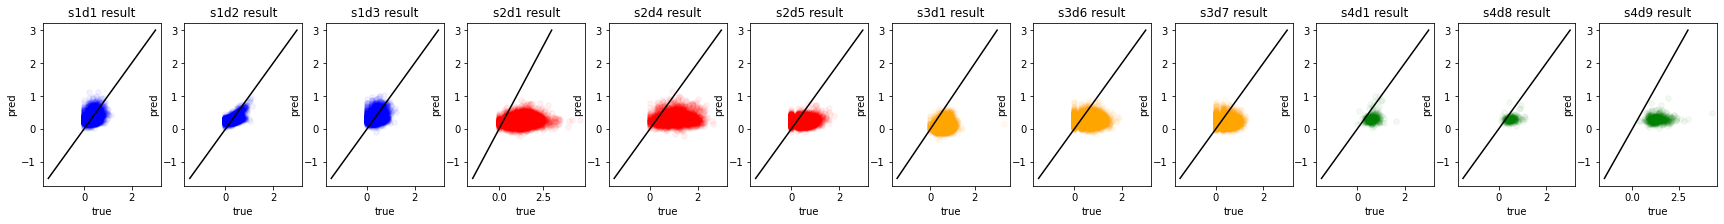

Epoch  2100 s1d1:  0.18972437 s1d2:  0.1452458 s1d3:  0.20060083 s2d1: 1.0768752 s2d4: 0.79112107 s2d5: 0.3489807 s3d1: 0.5001455 s3d6: 0.4181754 s3d7: 0.28826007 s4d1: 0.35387626 s4d8: 0.32392153 s4d9: 1.1341686 test loss: 0.8086872957823275
Epoch  2200 s1d1:  0.18990168 s1d2:  0.1446004 s1d3:  0.20076713 s2d1: 1.0764897 s2d4: 0.7911238 s2d5: 0.34885985 s3d1: 0.5008066 s3d6: 0.41813052 s3d7: 0.28836563 s4d1: 0.35374278 s4d8: 0.32364792 s4d9: 1.1340079 test loss: 0.8085416788528804
Epoch  2300 s1d1:  0.19002602 s1d2:  0.14396322 s1d3:  0.20087048 s2d1: 1.0762105 s2d4: 0.79130906 s2d5: 0.34886372 s3d1: 0.5014407 s3d6: 0.41820574 s3d7: 0.28860995 s4d1: 0.3536432 s4d8: 0.3234228 s4d9: 1.1338291 test loss: 0.8083933592501109
Epoch  2400 s1d1:  0.19045177 s1d2:  0.14332026 s1d3:  0.20119898 s2d1: 1.0757538 s2d4: 0.7910084 s2d5: 0.34877142 s3d1: 0.5019846 s3d6: 0.4182102 s3d7: 0.28877643 s4d1: 0.35349077 s4d8: 0.32310095 s4d9: 1.1336217 test loss: 0.8082109176846367
Epoch  2500 s1d1:  0.1905

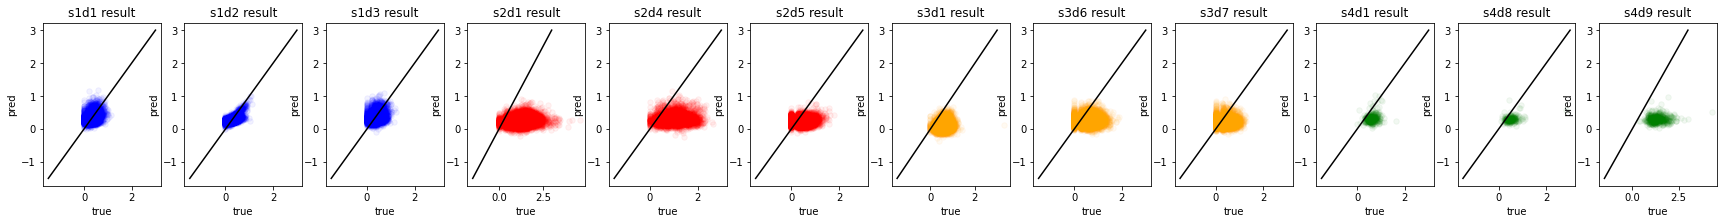

Epoch  3100 s1d1:  0.19222732 s1d2:  0.13893518 s1d3:  0.2029038 s2d1: 1.0742662 s2d4: 0.7916133 s2d5: 0.34882665 s3d1: 0.5062007 s3d6: 0.4185654 s3d7: 0.29027316 s4d1: 0.35323992 s4d8: 0.32206777 s4d9: 1.1331998 test loss: 0.8078172435335308
Epoch  3200 s1d1:  0.19256032 s1d2:  0.13831271 s1d3:  0.20321532 s2d1: 1.0740979 s2d4: 0.7916435 s2d5: 0.3488153 s3d1: 0.5065913 s3d6: 0.41867575 s3d7: 0.2905026 s4d1: 0.35316488 s4d8: 0.3218285 s4d9: 1.1330703 test loss: 0.8077031912163172
Epoch  3300 s1d1:  0.19285728 s1d2:  0.13769943 s1d3:  0.20349985 s2d1: 1.0740066 s2d4: 0.7915654 s2d5: 0.34893975 s3d1: 0.507676 s3d6: 0.41871652 s3d7: 0.29071566 s4d1: 0.352965 s4d8: 0.3215608 s4d9: 1.132756 test loss: 0.8074495119902453
Epoch  3400 s1d1:  0.19327073 s1d2:  0.13708194 s1d3:  0.20385449 s2d1: 1.0738086 s2d4: 0.7914056 s2d5: 0.34903795 s3d1: 0.5083823 s3d6: 0.4187587 s3d7: 0.29096085 s4d1: 0.35286543 s4d8: 0.32134432 s4d9: 1.1325799 test loss: 0.807303753265019
Epoch  3500 s1d1:  0.19335522 s1

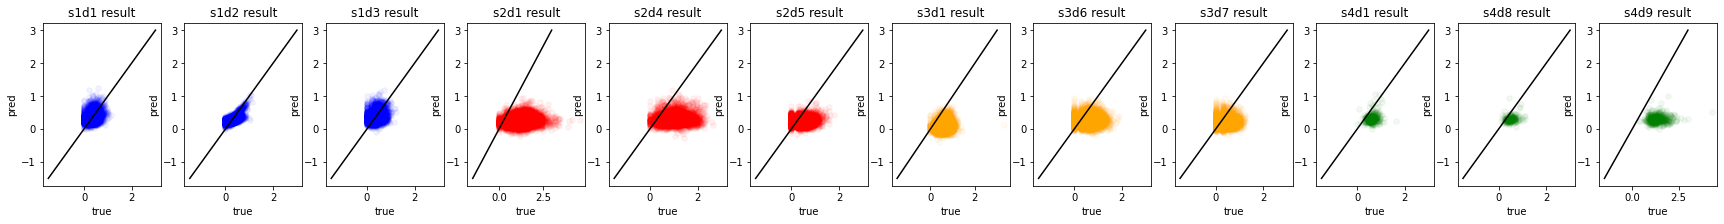

Epoch  4100 s1d1:  0.19526428 s1d2:  0.13278368 s1d3:  0.20571001 s2d1: 1.073469 s2d4: 0.7914842 s2d5: 0.35028332 s3d1: 0.5134494 s3d6: 0.41966802 s3d7: 0.29299185 s4d1: 0.352469 s4d8: 0.32004866 s4d9: 1.1314812 test loss: 0.8064317078573446
Epoch  4200 s1d1:  0.19574538 s1d2:  0.13215494 s1d3:  0.20614909 s2d1: 1.0735337 s2d4: 0.7913388 s2d5: 0.35057956 s3d1: 0.51456434 s3d6: 0.41987357 s3d7: 0.2933256 s4d1: 0.3523686 s4d8: 0.31973943 s4d9: 1.13117 test loss: 0.8061912961683853
Epoch  4300 s1d1:  0.19599381 s1d2:  0.13153088 s1d3:  0.20638056 s2d1: 1.0735518 s2d4: 0.7914437 s2d5: 0.3508401 s3d1: 0.51536155 s3d6: 0.42005476 s3d7: 0.29366824 s4d1: 0.35231146 s4d8: 0.31956872 s4d9: 1.1309873 test loss: 0.8060512441806994
Epoch  4400 s1d1:  0.19631527 s1d2:  0.13090438 s1d3:  0.20668414 s2d1: 1.073609 s2d4: 0.79146236 s2d5: 0.35109133 s3d1: 0.5160835 s3d6: 0.4202435 s3d7: 0.29399592 s4d1: 0.35238266 s4d8: 0.31943527 s4d9: 1.1309171 test loss: 0.8060054775308079
Epoch  4500 s1d1:  0.196717

In [34]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s1d2, pro_s1d2)

Epoch  0 s1d1:  0.30114165 s1d2:  0.3103576 s1d3:  0.28613606 s2d1: 1.1462873 s2d4: 0.9482841 s2d5: 0.43524757 s3d1: 0.5012719 s3d6: 0.50911474 s3d7: 0.3838923 s4d1: 0.561643 s4d8: 0.5317876 s4d9: 1.3190868 test loss: 0.9810976067582807


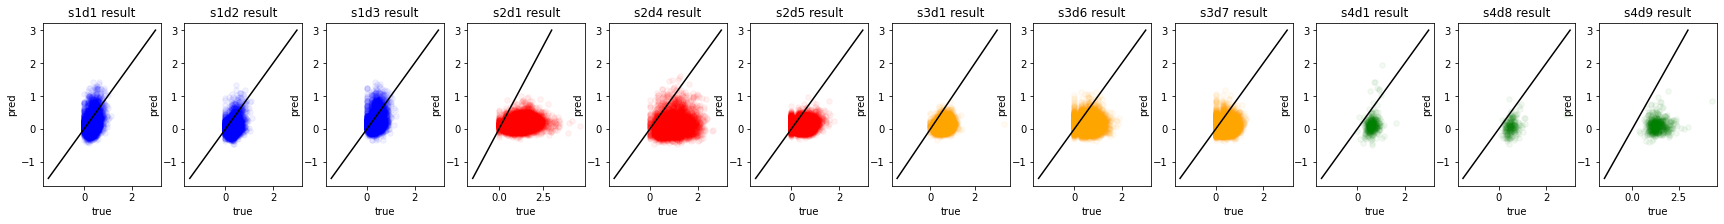

Epoch  100 s1d1:  0.19532253 s1d2:  0.1947033 s1d3:  0.19636042 s2d1: 1.0910305 s2d4: 0.7780389 s2d5: 0.36796424 s3d1: 0.50619876 s3d6: 0.42102855 s3d7: 0.29684314 s4d1: 0.36175448 s4d8: 0.3123948 s4d9: 1.1138564 test loss: 0.7958523354687557
Epoch  200 s1d1:  0.18928888 s1d2:  0.1877353 s1d3:  0.18769279 s2d1: 1.0830067 s2d4: 0.77127326 s2d5: 0.36265507 s3d1: 0.49667728 s3d6: 0.4144958 s3d7: 0.29282632 s4d1: 0.35296482 s4d8: 0.30817774 s4d9: 1.1085013 test loss: 0.7907454831594051
Epoch  300 s1d1:  0.18655154 s1d2:  0.18404701 s1d3:  0.18318804 s2d1: 1.0789466 s2d4: 0.7691717 s2d5: 0.36020315 s3d1: 0.49207032 s3d6: 0.4116366 s3d7: 0.29082093 s4d1: 0.34861845 s4d8: 0.30629727 s4d9: 1.1056005 test loss: 0.7880816618083698
Epoch  400 s1d1:  0.18495311 s1d2:  0.18187726 s1d3:  0.18020998 s2d1: 1.0761595 s2d4: 0.7676663 s2d5: 0.35872546 s3d1: 0.48971513 s3d6: 0.4097867 s3d7: 0.28938597 s4d1: 0.3454046 s4d8: 0.30439237 s4d9: 1.103031 test loss: 0.7858003009931872
Epoch  500 s1d1:  0.1838381

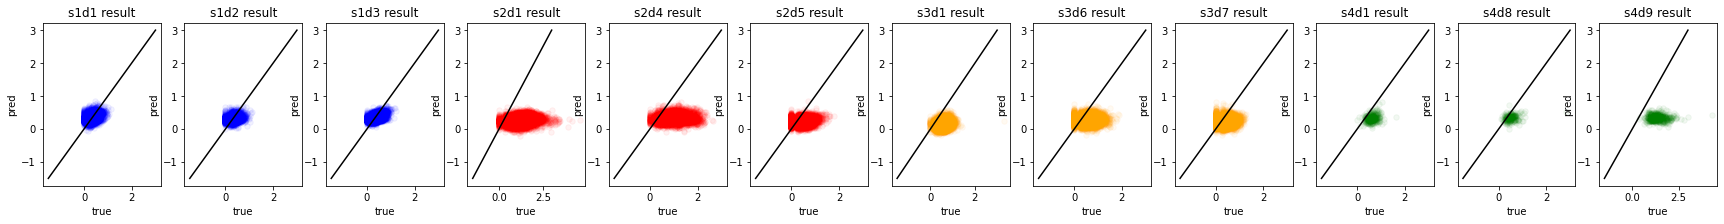

Epoch  1100 s1d1:  0.18153538 s1d2:  0.1762715 s1d3:  0.16996306 s2d1: 1.0617808 s2d4: 0.7671229 s2d5: 0.3490105 s3d1: 0.45502385 s3d6: 0.4036214 s3d7: 0.2821506 s4d1: 0.34241655 s4d8: 0.30498907 s4d9: 1.1040094 test loss: 0.7860420318551146
Epoch  1200 s1d1:  0.18143746 s1d2:  0.17598048 s1d3:  0.16901717 s2d1: 1.0608745 s2d4: 0.76749706 s2d5: 0.34860483 s3d1: 0.45235577 s3d6: 0.40355211 s3d7: 0.28190342 s4d1: 0.34292507 s4d8: 0.30549374 s4d9: 1.1047502 test loss: 0.786634124160146
Epoch  1300 s1d1:  0.1813323 s1d2:  0.175749 s1d3:  0.16811265 s2d1: 1.0601352 s2d4: 0.7678503 s2d5: 0.34822795 s3d1: 0.4501977 s3d6: 0.4035115 s3d7: 0.2816442 s4d1: 0.34346813 s4d8: 0.30601573 s4d9: 1.1055735 test loss: 0.7872859607523875
Epoch  1400 s1d1:  0.18126218 s1d2:  0.17559128 s1d3:  0.16725226 s2d1: 1.0596309 s2d4: 0.76829916 s2d5: 0.3479658 s3d1: 0.4488379 s3d6: 0.40358746 s3d7: 0.28146827 s4d1: 0.34399128 s4d8: 0.30654317 s4d9: 1.106269 test loss: 0.7878529056301392
Epoch  1500 s1d1:  0.1812245

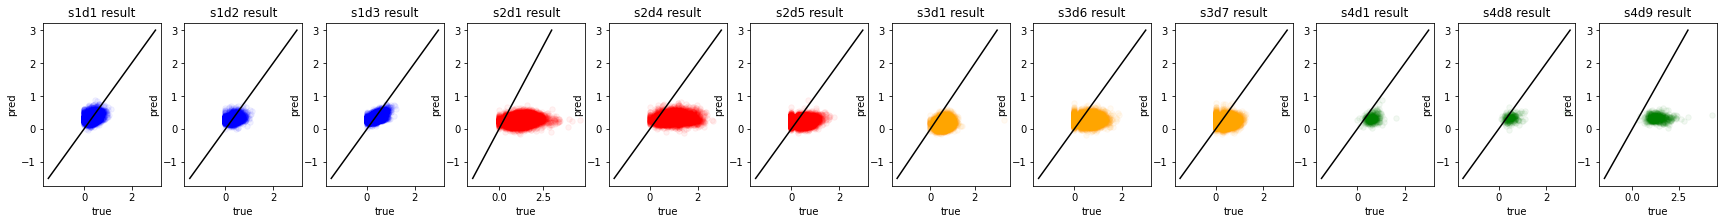

Epoch  2100 s1d1:  0.18150602 s1d2:  0.17555286 s1d3:  0.16163492 s2d1: 1.0567713 s2d4: 0.7700431 s2d5: 0.34784356 s3d1: 0.44311175 s3d6: 0.40433717 s3d7: 0.28156915 s4d1: 0.3477403 s4d8: 0.30994627 s4d9: 1.1104867 test loss: 0.7913938085429146
Epoch  2200 s1d1:  0.1816148 s1d2:  0.17563367 s1d3:  0.16086285 s2d1: 1.0566727 s2d4: 0.77029085 s2d5: 0.34802374 s3d1: 0.4428213 s3d6: 0.40461248 s3d7: 0.28180248 s4d1: 0.34832028 s4d8: 0.31046614 s4d9: 1.1110628 test loss: 0.7918921323714743
Epoch  2300 s1d1:  0.18169068 s1d2:  0.17571811 s1d3:  0.16009521 s2d1: 1.0565915 s2d4: 0.77061003 s2d5: 0.34817675 s3d1: 0.44265264 s3d6: 0.40489033 s3d7: 0.28202048 s4d1: 0.349023 s4d8: 0.31105173 s4d9: 1.1117848 test loss: 0.7925079661527012
Epoch  2400 s1d1:  0.18177524 s1d2:  0.17584193 s1d3:  0.1593276 s2d1: 1.0564678 s2d4: 0.7708813 s2d5: 0.34824193 s3d1: 0.44250897 s3d6: 0.4050612 s3d7: 0.28217542 s4d1: 0.34949327 s4d8: 0.3114495 s4d9: 1.1122689 test loss: 0.7929212110767212
Epoch  2500 s1d1:  0.1

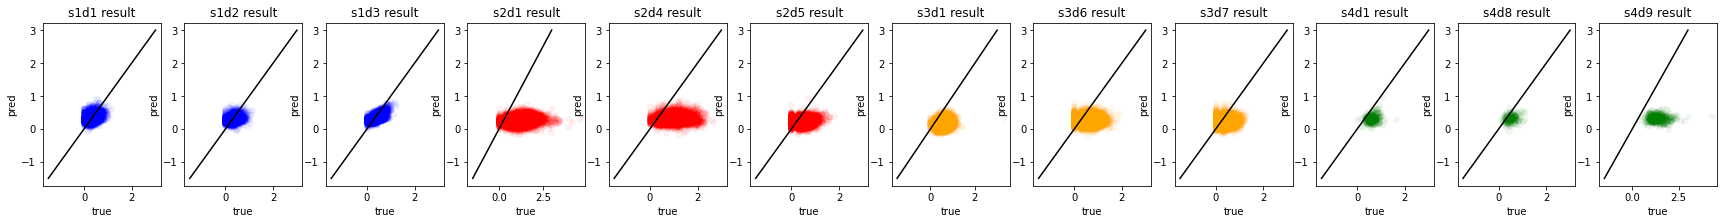

Epoch  3100 s1d1:  0.18277691 s1d2:  0.17697194 s1d3:  0.15400623 s2d1: 1.0569165 s2d4: 0.7725096 s2d5: 0.35009328 s3d1: 0.44348 s3d6: 0.40699917 s3d7: 0.28426436 s4d1: 0.35319668 s4d8: 0.31483325 s4d9: 1.11595 test loss: 0.7961135042713905
Epoch  3200 s1d1:  0.18289502 s1d2:  0.17718099 s1d3:  0.15325211 s2d1: 1.0572222 s2d4: 0.772833 s2d5: 0.35050762 s3d1: 0.4445904 s3d6: 0.40736958 s3d7: 0.28463057 s4d1: 0.35368538 s4d8: 0.3153144 s4d9: 1.1164339 test loss: 0.7965366562217947
Epoch  3300 s1d1:  0.18309334 s1d2:  0.1773832 s1d3:  0.1525017 s2d1: 1.0573454 s2d4: 0.77302057 s2d5: 0.35087225 s3d1: 0.44506714 s3d6: 0.40766117 s3d7: 0.2850274 s4d1: 0.3539896 s4d8: 0.3156975 s4d9: 1.1166625 test loss: 0.7967602793963986
Epoch  3400 s1d1:  0.1832524 s1d2:  0.1775943 s1d3:  0.15175419 s2d1: 1.0576012 s2d4: 0.7732341 s2d5: 0.3514056 s3d1: 0.44587624 s3d6: 0.4080175 s3d7: 0.28546828 s4d1: 0.35441998 s4d8: 0.3160796 s4d9: 1.1169543 test loss: 0.7970432481561897
Epoch  3500 s1d1:  0.18349236 s1d

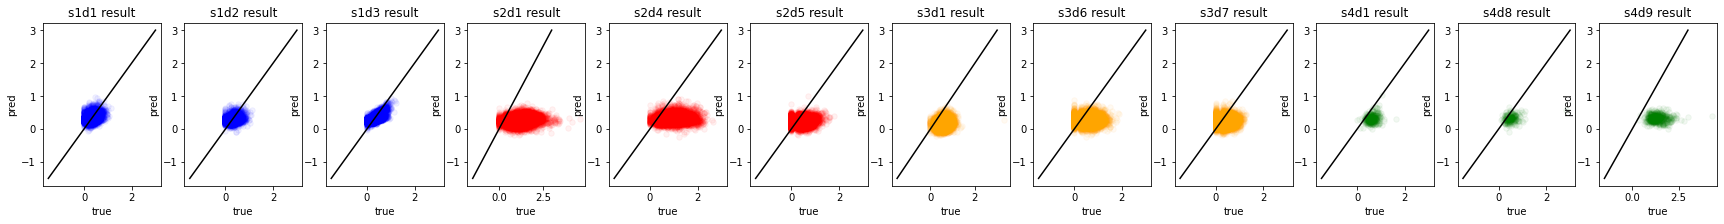

Epoch  4100 s1d1:  0.18474913 s1d2:  0.1792122 s1d3:  0.14657336 s2d1: 1.0585876 s2d4: 0.77363074 s2d5: 0.35457283 s3d1: 0.44988552 s3d6: 0.40995696 s3d7: 0.28827134 s4d1: 0.35647127 s4d8: 0.31820917 s4d9: 1.1181741 test loss: 0.7983082000014008
Epoch  4200 s1d1:  0.1848461 s1d2:  0.17945491 s1d3:  0.14584014 s2d1: 1.0589701 s2d4: 0.77389854 s2d5: 0.35505173 s3d1: 0.45082957 s3d6: 0.41022927 s3d7: 0.28859907 s4d1: 0.35682285 s4d8: 0.31854424 s4d9: 1.1184345 test loss: 0.798555763023528
Epoch  4300 s1d1:  0.18505026 s1d2:  0.17968783 s1d3:  0.14510916 s2d1: 1.0591435 s2d4: 0.77391565 s2d5: 0.35554352 s3d1: 0.4515908 s3d6: 0.4105405 s3d7: 0.28903615 s4d1: 0.3570635 s4d8: 0.31880426 s4d9: 1.1185519 test loss: 0.7986885677792159
Epoch  4400 s1d1:  0.18519405 s1d2:  0.1799472 s1d3:  0.14438298 s2d1: 1.0595571 s2d4: 0.77418286 s2d5: 0.35614672 s3d1: 0.45261025 s3d6: 0.41090763 s3d7: 0.28948498 s4d1: 0.35753953 s4d8: 0.31920606 s4d9: 1.1189115 test loss: 0.7990240597448581
Epoch  4500 s1d1:  

In [35]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s1d3, pro_s1d3)

Epoch  0 s1d1:  0.305035 s1d2:  0.3137795 s1d3:  0.28921413 s2d1: 1.1355298 s2d4: 0.94367653 s2d5: 0.43071613 s3d1: 0.48800933 s3d6: 0.5052438 s3d7: 0.38192308 s4d1: 0.56170785 s4d8: 0.5337088 s4d9: 1.3186138 test loss: 0.9810340818579906


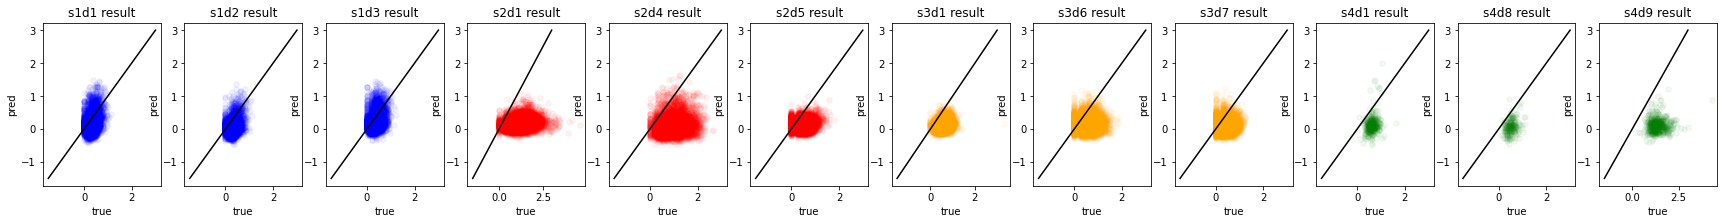

Epoch  100 s1d1:  0.5654688 s1d2:  0.35574436 s1d3:  0.56356984 s2d1: 0.50429094 s2d4: 0.5420188 s2d5: 0.7064471 s3d1: 0.6952833 s3d6: 0.58646494 s3d7: 0.54406434 s4d1: 0.3622792 s4d8: 0.33999014 s4d9: 0.73392797 test loss: 0.5612526401994515
Epoch  200 s1d1:  0.6376549 s1d2:  0.42359465 s1d3:  0.62722015 s2d1: 0.49539354 s2d4: 0.5133969 s2d5: 0.72189397 s3d1: 0.6322411 s3d6: 0.6085939 s3d7: 0.5792046 s4d1: 0.42030662 s4d8: 0.39040104 s4d9: 0.6389634 test loss: 0.5272105993655284
Epoch  300 s1d1:  0.6863775 s1d2:  0.47555614 s1d3:  0.6695944 s2d1: 0.48982385 s2d4: 0.50319815 s2d5: 0.7285294 s3d1: 0.6046485 s3d6: 0.6208439 s3d7: 0.6019445 s4d1: 0.46152282 s4d8: 0.43793702 s4d9: 0.5891508 test loss: 0.5197707896174548
Epoch  400 s1d1:  0.7214745 s1d2:  0.51650053 s1d3:  0.7004659 s2d1: 0.4856579 s2d4: 0.49850705 s2d5: 0.7326439 s3d1: 0.58712965 s3d6: 0.6289727 s3d7: 0.6189381 s4d1: 0.49116802 s4d8: 0.47564414 s4d9: 0.5582001 test loss: 0.5200249095943078
Epoch  500 s1d1:  0.7511932 s1d2:

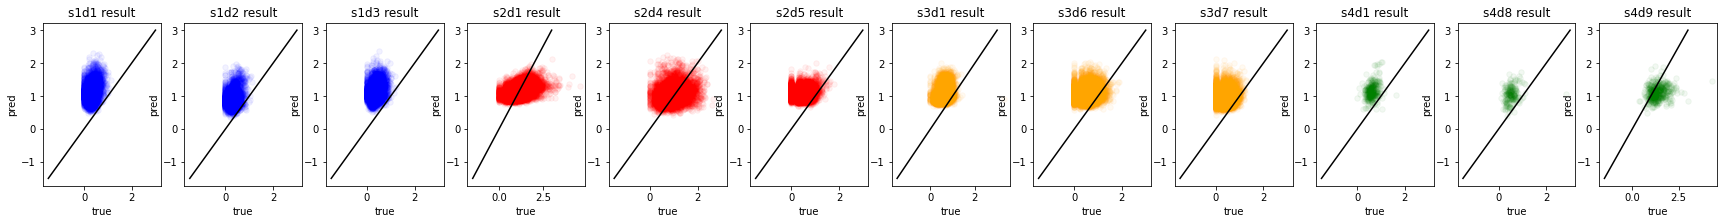

Epoch  1100 s1d1:  0.87334657 s1d2:  0.6836602 s1d3:  0.8333407 s2d1: 0.4673336 s2d4: 0.5146795 s2d5: 0.74927384 s3d1: 0.5362035 s3d6: 0.6627133 s3d7: 0.6855741 s4d1: 0.60660696 s4d8: 0.62661093 s4d9: 0.4819289 test loss: 0.5574806364854599
Epoch  1200 s1d1:  0.888468 s1d2:  0.6990114 s1d3:  0.84680647 s2d1: 0.46515548 s2d4: 0.5187509 s2d5: 0.7515181 s3d1: 0.53264487 s3d6: 0.6661012 s3d7: 0.6911448 s4d1: 0.6173542 s4d8: 0.6404285 s4d9: 0.47817227 test loss: 0.5631577871782274
Epoch  1300 s1d1:  0.903768 s1d2:  0.71383965 s1d3:  0.86036867 s2d1: 0.46299157 s2d4: 0.523404 s2d5: 0.75278884 s3d1: 0.5287238 s3d6: 0.6688971 s3d7: 0.6961434 s4d1: 0.62871236 s4d8: 0.65437365 s4d9: 0.4749111 test loss: 0.56937226932344
Epoch  1400 s1d1:  0.9172822 s1d2:  0.7273549 s1d3:  0.87219304 s2d1: 0.4608428 s2d4: 0.5274334 s2d5: 0.7544123 s3d1: 0.52404493 s3d6: 0.6714261 s3d7: 0.7011162 s4d1: 0.6385352 s4d8: 0.66690886 s4d9: 0.4729983 test loss: 0.575272644764073
Epoch  1500 s1d1:  0.9296089 s1d2:  0.739

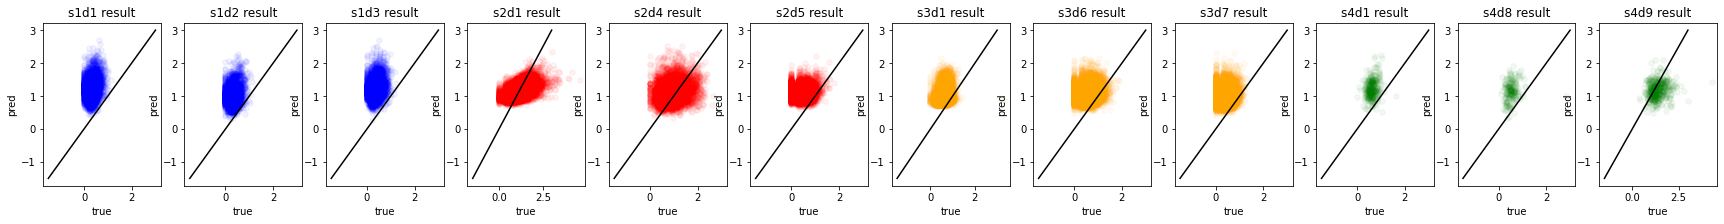

Epoch  2100 s1d1:  0.9854705 s1d2:  0.7874843 s1d3:  0.9329175 s2d1: 0.44542497 s2d4: 0.5544672 s2d5: 0.7646085 s3d1: 0.5046609 s3d6: 0.68636936 s3d7: 0.728371 s4d1: 0.6883203 s4d8: 0.723589 s4d9: 0.47965074 test loss: 0.6101025747875239
Epoch  2200 s1d1:  0.9924249 s1d2:  0.7938457 s1d3:  0.93860924 s2d1: 0.44308874 s2d4: 0.55802816 s2d5: 0.7666872 s3d1: 0.5026106 s3d6: 0.6886923 s3d7: 0.7323756 s4d1: 0.69447833 s4d8: 0.7309022 s4d9: 0.48199588 test loss: 0.6150660734402318
Epoch  2300 s1d1:  1.0014842 s1d2:  0.8013836 s1d3:  0.94646823 s2d1: 0.44069508 s2d4: 0.56257457 s2d5: 0.76782584 s3d1: 0.50079715 s3d6: 0.6907185 s3d7: 0.73604554 s4d1: 0.70200855 s4d8: 0.73949105 s4d9: 0.48417068 test loss: 0.620803687842086
Epoch  2400 s1d1:  1.009407 s1d2:  0.8081688 s1d3:  0.9537989 s2d1: 0.4382396 s2d4: 0.56705964 s2d5: 0.7699595 s3d1: 0.4984415 s3d6: 0.69331545 s3d7: 0.7400002 s4d1: 0.7091595 s4d8: 0.7474596 s4d9: 0.4867186 test loss: 0.6263831531427576
Epoch  2500 s1d1:  1.0185245 s1d2:  0

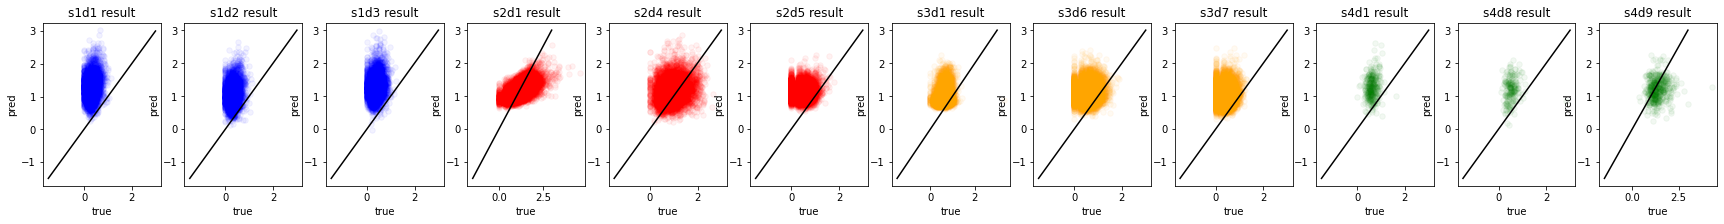

Epoch  3100 s1d1:  1.0559701 s1d2:  0.8367215 s1d3:  0.997219 s2d1: 0.4193826 s2d4: 0.5978081 s2d5: 0.77976716 s3d1: 0.4821034 s3d6: 0.70858204 s3d7: 0.7645227 s4d1: 0.7524996 s4d8: 0.78733283 s4d9: 0.51611096 test loss: 0.663107303483027
Epoch  3200 s1d1:  1.0606141 s1d2:  0.8374692 s1d3:  1.001727 s2d1: 0.416482 s2d4: 0.60192776 s2d5: 0.7803884 s3d1: 0.48018304 s3d6: 0.71025884 s3d7: 0.76699066 s4d1: 0.75709677 s4d8: 0.78970665 s4d9: 0.5215038 test loss: 0.6673624008669934
Epoch  3300 s1d1:  1.0656965 s1d2:  0.8389074 s1d3:  1.0071827 s2d1: 0.41352022 s2d4: 0.6063257 s2d5: 0.78105426 s3d1: 0.47716933 s3d6: 0.7120112 s3d7: 0.76953614 s4d1: 0.7622906 s4d8: 0.79324996 s4d9: 0.5267029 test loss: 0.672064558523923
Epoch  3400 s1d1:  1.0687429 s1d2:  0.84037375 s1d3:  1.011295 s2d1: 0.4104886 s2d4: 0.60960543 s2d5: 0.7833082 s3d1: 0.47572374 s3d6: 0.7141771 s3d7: 0.77294195 s4d1: 0.7667334 s4d8: 0.795763 s4d9: 0.53173506 test loss: 0.6761738327897155
Epoch  3500 s1d1:  1.0734627 s1d2:  0.8

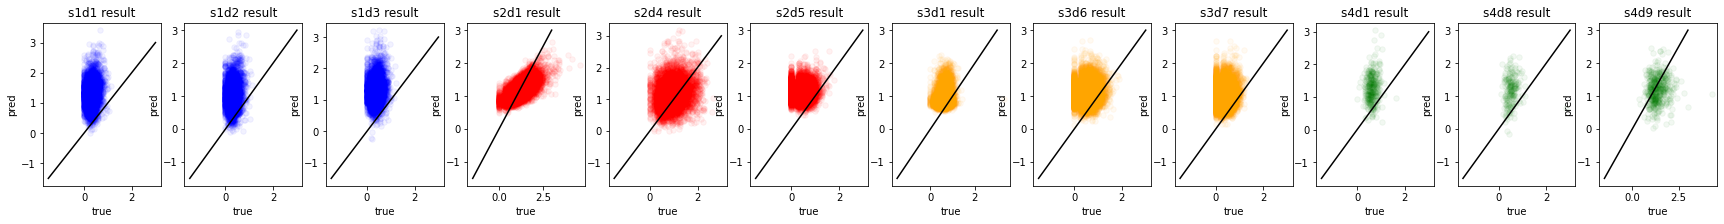

Epoch  4100 s1d1:  1.0923723 s1d2:  0.8398727 s1d3:  1.0382093 s2d1: 0.38757452 s2d4: 0.6358319 s2d5: 0.7907081 s3d1: 0.46276686 s3d6: 0.7259755 s3d7: 0.7915527 s4d1: 0.79895437 s4d8: 0.8105202 s4d9: 0.5715961 test loss: 0.7065084627131266
Epoch  4200 s1d1:  1.0956562 s1d2:  0.8388182 s1d3:  1.0424336 s2d1: 0.38408712 s2d4: 0.63987005 s2d5: 0.7916199 s3d1: 0.46127644 s3d6: 0.727744 s3d7: 0.79411596 s4d1: 0.80350417 s4d8: 0.8121285 s4d9: 0.5774489 test loss: 0.7107857848505148
Epoch  4300 s1d1:  1.0980746 s1d2:  0.83694816 s1d3:  1.0454155 s2d1: 0.3805326 s2d4: 0.6435169 s2d5: 0.792584 s3d1: 0.46033642 s3d6: 0.7293102 s3d7: 0.7969841 s4d1: 0.8070794 s4d8: 0.81210464 s4d9: 0.58452517 test loss: 0.7147767032386453
Epoch  4400 s1d1:  1.09961 s1d2:  0.83572465 s1d3:  1.0480659 s2d1: 0.37696707 s2d4: 0.64636594 s2d5: 0.79381055 s3d1: 0.45908526 s3d6: 0.7307834 s3d7: 0.7992519 s4d1: 0.8107038 s4d8: 0.8132339 s4d9: 0.5908674 test loss: 0.7187946611087599
Epoch  4500 s1d1:  1.1019248 s1d2:  0.8

In [36]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s2d1, pro_s2d1)

Epoch  0 s1d1:  0.30390704 s1d2:  0.3126954 s1d3:  0.2893183 s2d1: 1.1445997 s2d4: 0.94893116 s2d5: 0.4328271 s3d1: 0.49667343 s3d6: 0.5084923 s3d7: 0.38243955 s4d1: 0.5644031 s4d8: 0.5349877 s4d9: 1.3229247 test loss: 0.9843533048661041


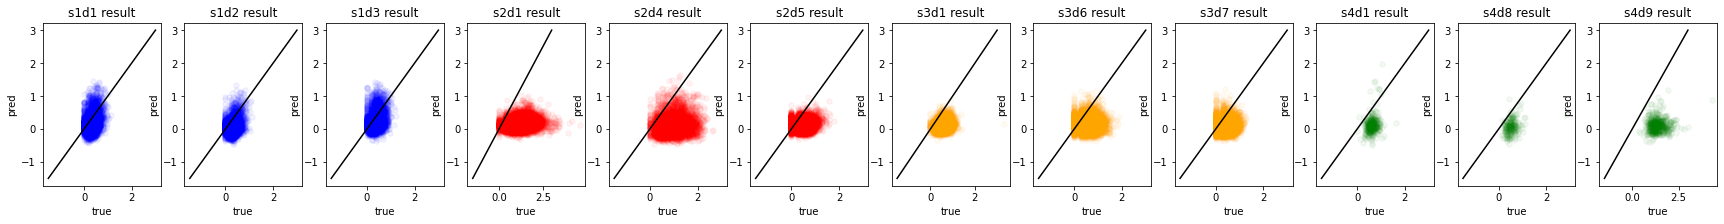

Epoch  100 s1d1:  0.3292326 s1d2:  0.24426712 s1d3:  0.31358957 s2d1: 0.9234169 s2d4: 0.7443815 s2d5: 0.289195 s3d1: 0.2886478 s3d6: 0.36793756 s3d7: 0.28253177 s4d1: 0.39353868 s4d8: 0.36665493 s4d9: 1.1437913 test loss: 0.824649238273431
Epoch  200 s1d1:  0.35188246 s1d2:  0.24505836 s1d3:  0.32380968 s2d1: 0.9063157 s2d4: 0.7010348 s2d5: 0.28347528 s3d1: 0.29345736 s3d6: 0.35894293 s3d7: 0.2807171 s4d1: 0.3503273 s4d8: 0.31901428 s4d9: 1.0826141 test loss: 0.7746162931861443
Epoch  300 s1d1:  0.36978474 s1d2:  0.2521009 s1d3:  0.33296543 s2d1: 0.89905095 s2d4: 0.67936546 s2d5: 0.2801382 s3d1: 0.29577842 s3d6: 0.35614038 s3d7: 0.28074372 s4d1: 0.3303967 s4d8: 0.2990379 s4d9: 1.0484043 test loss: 0.7479848885712631
Epoch  400 s1d1:  0.38408843 s1d2:  0.26043862 s1d3:  0.34134308 s2d1: 0.8949102 s2d4: 0.6656623 s2d5: 0.27778172 s3d1: 0.29636857 s3d6: 0.35456195 s3d7: 0.28088897 s4d1: 0.319205 s4d8: 0.28866962 s4d9: 1.025325 test loss: 0.7306325223336025
Epoch  500 s1d1:  0.3962039 s1d2

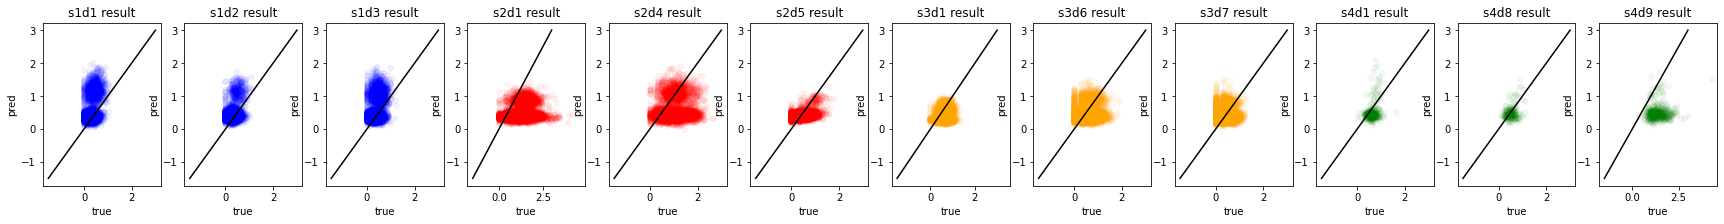

Epoch  1100 s1d1:  0.43574676 s1d2:  0.3024464 s1d3:  0.3769944 s2d1: 0.8887791 s2d4: 0.63127285 s2d5: 0.2692826 s3d1: 0.30399624 s3d6: 0.35244533 s3d7: 0.28163385 s4d1: 0.30257344 s4d8: 0.2766257 s4d9: 0.9668893 test loss: 0.6895835987024046
Epoch  1200 s1d1:  0.4410741 s1d2:  0.3069733 s1d3:  0.38121837 s2d1: 0.8885927 s2d4: 0.6292062 s2d5: 0.26841366 s3d1: 0.30554077 s3d6: 0.35272136 s3d7: 0.2818719 s4d1: 0.3026507 s4d8: 0.27697515 s4d9: 0.9630658 test loss: 0.6871638328339522
Epoch  1300 s1d1:  0.44564486 s1d2:  0.31101966 s1d3:  0.38479352 s2d1: 0.8884076 s2d4: 0.62740105 s2d5: 0.26756158 s3d1: 0.3073536 s3d6: 0.35309574 s3d7: 0.28209978 s4d1: 0.3024733 s4d8: 0.2774636 s4d9: 0.959363 test loss: 0.684797045416076
Epoch  1400 s1d1:  0.44977102 s1d2:  0.31504366 s1d3:  0.38798732 s2d1: 0.8885478 s2d4: 0.6255603 s2d5: 0.26672116 s3d1: 0.3095562 s3d6: 0.3533924 s3d7: 0.28227302 s4d1: 0.3023655 s4d8: 0.2780514 s4d9: 0.9558433 test loss: 0.682567763098725
Epoch  1500 s1d1:  0.45547473 s1

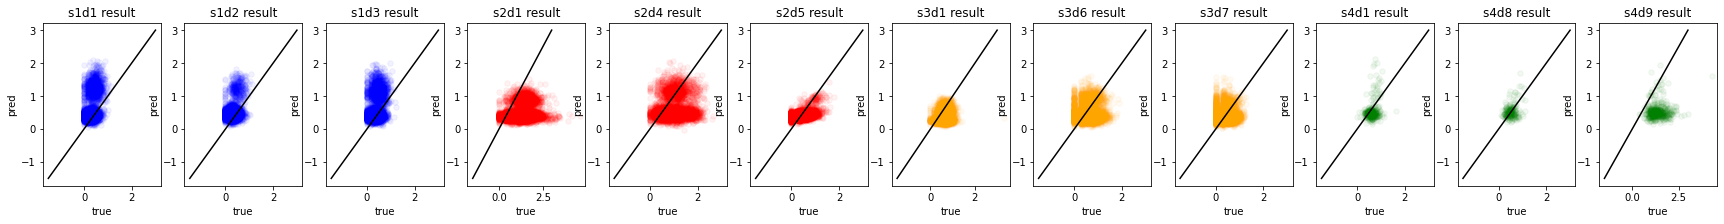

Epoch  2100 s1d1:  0.47682455 s1d2:  0.33927283 s1d3:  0.4098547 s2d1: 0.8899197 s2d4: 0.6187407 s2d5: 0.26073796 s3d1: 0.32471895 s3d6: 0.35720056 s3d7: 0.28425407 s4d1: 0.30564362 s4d8: 0.28527316 s4d9: 0.9367389 test loss: 0.6714243556733592
Epoch  2200 s1d1:  0.48012373 s1d2:  0.34241238 s1d3:  0.41231123 s2d1: 0.89032733 s2d4: 0.6181699 s2d5: 0.2598471 s3d1: 0.32698312 s3d6: 0.35790306 s3d7: 0.28464136 s4d1: 0.30632606 s4d8: 0.28660458 s4d9: 0.93481094 test loss: 0.6704114887754974
Epoch  2300 s1d1:  0.48425993 s1d2:  0.3460442 s1d3:  0.41576943 s2d1: 0.8906354 s2d4: 0.6175265 s2d5: 0.25894144 s3d1: 0.32916537 s3d6: 0.35858053 s3d7: 0.28505564 s4d1: 0.30723035 s4d8: 0.2881091 s4d9: 0.93216413 test loss: 0.6689900622860605
Epoch  2400 s1d1:  0.48871386 s1d2:  0.3499275 s1d3:  0.4193309 s2d1: 0.8908285 s2d4: 0.6168602 s2d5: 0.25802776 s3d1: 0.33143377 s3d6: 0.35928524 s3d7: 0.28552863 s4d1: 0.30830747 s4d8: 0.2898622 s4d9: 0.9294723 test loss: 0.6675917504897206
Epoch  2500 s1d1:  0

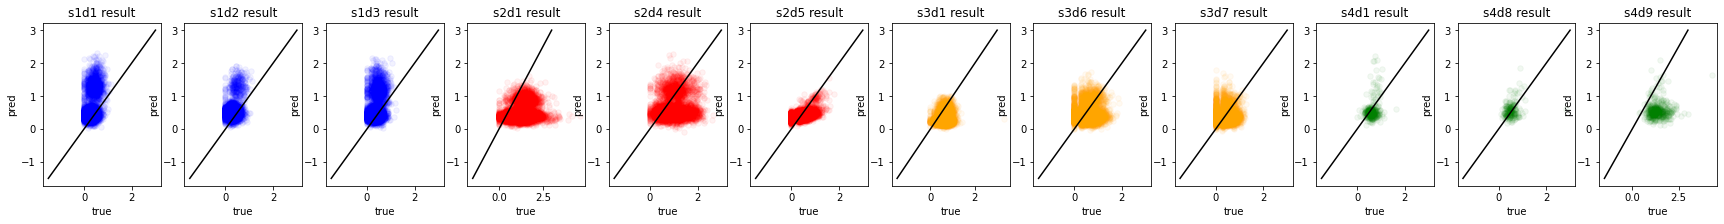

Epoch  3100 s1d1:  0.5146365 s1d2:  0.3747528 s1d3:  0.44000882 s2d1: 0.8935736 s2d4: 0.6136459 s2d5: 0.25124025 s3d1: 0.34716725 s3d6: 0.36423138 s3d7: 0.28915536 s4d1: 0.31546876 s4d8: 0.3035167 s4d9: 0.91371566 test loss: 0.6599374299662152
Epoch  3200 s1d1:  0.5195332 s1d2:  0.3788035 s1d3:  0.4441629 s2d1: 0.8936447 s2d4: 0.6134456 s2d5: 0.25022143 s3d1: 0.34878302 s3d6: 0.36511847 s3d7: 0.2899727 s4d1: 0.31742328 s4d8: 0.30595016 s4d9: 0.9118161 test loss: 0.6592768112517241
Epoch  3300 s1d1:  0.521738 s1d2:  0.38190722 s1d3:  0.44591197 s2d1: 0.89433396 s2d4: 0.6129956 s2d5: 0.24919449 s3d1: 0.35103348 s3d6: 0.36561155 s3d7: 0.2904084 s4d1: 0.31791595 s4d8: 0.3079434 s4d9: 0.90984297 test loss: 0.6582962268331696
Epoch  3400 s1d1:  0.52680314 s1d2:  0.38593957 s1d3:  0.45032197 s2d1: 0.894345 s2d4: 0.61293393 s2d5: 0.24815007 s3d1: 0.352733 s3d6: 0.36654976 s3d7: 0.29134068 s4d1: 0.31997615 s4d8: 0.31059757 s4d9: 0.90778834 test loss: 0.6575853913938926
Epoch  3500 s1d1:  0.5291

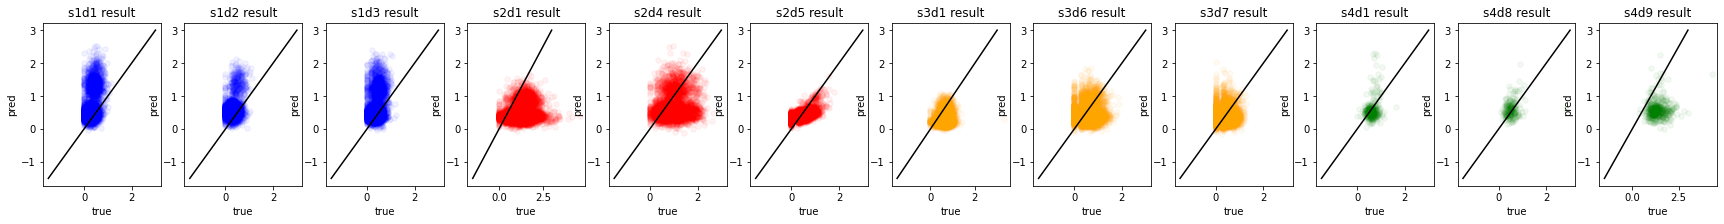

Epoch  4100 s1d1:  0.55156726 s1d2:  0.40990055 s1d3:  0.47112954 s2d1: 0.8962847 s2d4: 0.6125974 s2d5: 0.24058343 s3d1: 0.36421716 s3d6: 0.37180752 s3d7: 0.29669705 s4d1: 0.33065078 s4d8: 0.32793835 s4d9: 0.89635813 test loss: 0.6538844694705462
Epoch  4200 s1d1:  0.5538135 s1d2:  0.41307908 s1d3:  0.4728961 s2d1: 0.89655685 s2d4: 0.6122471 s2d5: 0.23945574 s3d1: 0.3658593 s3d6: 0.37234765 s3d7: 0.2973709 s4d1: 0.331416 s4d8: 0.3304356 s4d9: 0.8943306 test loss: 0.6529992235203835
Epoch  4300 s1d1:  0.5585352 s1d2:  0.41678807 s1d3:  0.47702113 s2d1: 0.8966286 s2d4: 0.6126889 s2d5: 0.23831657 s3d1: 0.36733833 s3d6: 0.37338045 s3d7: 0.29845977 s4d1: 0.3339811 s4d8: 0.3333594 s4d9: 0.8932171 test loss: 0.6530437698625858
Epoch  4400 s1d1:  0.56174177 s1d2:  0.42011347 s1d3:  0.4796951 s2d1: 0.8965743 s2d4: 0.6127748 s2d5: 0.23716958 s3d1: 0.36853296 s3d6: 0.3741161 s3d7: 0.2993669 s4d1: 0.33547682 s4d8: 0.33611998 s4d9: 0.8913837 test loss: 0.6524426276942518
Epoch  4500 s1d1:  0.565181

In [33]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s2d5, pro_s2d5)

Epoch  0 s1d1:  0.30806634 s1d2:  0.31934935 s1d3:  0.29274788 s2d1: 1.1413851 s2d4: 0.95256746 s2d5: 0.43221918 s3d1: 0.48167726 s3d6: 0.5089322 s3d7: 0.38333687 s4d1: 0.57114947 s4d8: 0.5437444 s4d9: 1.331241 test loss: 0.9917645443352755


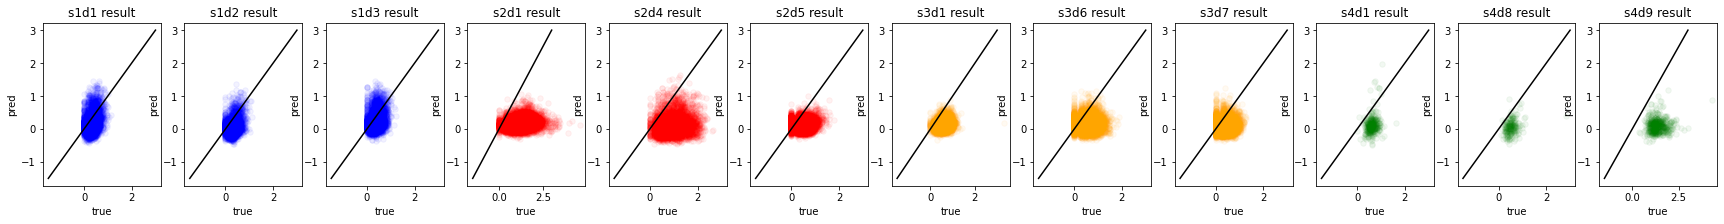

Epoch  100 s1d1:  0.39534014 s1d2:  0.5001493 s1d3:  0.34985855 s2d1: 1.0080854 s2d4: 1.0413593 s2d5: 0.35250276 s3d1: 0.20558113 s3d6: 0.4613112 s3d7: 0.3397138 s4d1: 0.7014126 s4d8: 0.75680727 s4d9: 1.5243384 test loss: 1.1616444260834373
Epoch  200 s1d1:  0.3983472 s1d2:  0.5106399 s1d3:  0.3483033 s2d1: 0.99503124 s2d4: 1.035269 s2d5: 0.34532323 s3d1: 0.20130406 s3d6: 0.45117575 s3d7: 0.33067378 s4d1: 0.69870055 s4d8: 0.76044273 s4d9: 1.5241922 test loss: 1.1615019468349885
Epoch  300 s1d1:  0.39466056 s1d2:  0.50937843 s1d3:  0.34248638 s2d1: 0.98608696 s2d4: 1.0259557 s2d5: 0.34033486 s3d1: 0.19864692 s3d6: 0.44324735 s3d7: 0.32408234 s4d1: 0.68862444 s4d8: 0.75240076 s4d9: 1.5145915 test loss: 1.152609343280823
Epoch  400 s1d1:  0.38845176 s1d2:  0.5032185 s1d3:  0.33515444 s2d1: 0.9788845 s2d4: 1.0161451 s2d5: 0.33630678 s3d1: 0.19682305 s3d6: 0.43647352 s3d7: 0.3187429 s4d1: 0.67672175 s4d8: 0.74130857 s4d9: 1.5026516 test loss: 1.1415406088893005
Epoch  500 s1d1:  0.38103613 

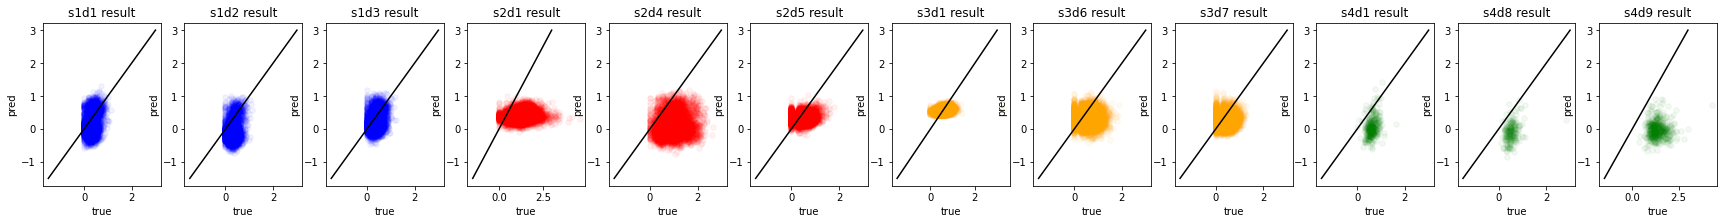

Epoch  1100 s1d1:  0.35608616 s1d2:  0.4656997 s1d3:  0.30170038 s2d1: 0.94747186 s2d4: 0.97495466 s2d5: 0.32132146 s3d1: 0.19117397 s3d6: 0.40920746 s3d7: 0.2988475 s4d1: 0.6242127 s4d8: 0.6954028 s4d9: 1.4500715 test loss: 1.093336607357658
Epoch  1200 s1d1:  0.35374674 s1d2:  0.4632513 s1d3:  0.29949397 s2d1: 0.94465095 s2d4: 0.9722812 s2d5: 0.3202385 s3d1: 0.19075416 s3d6: 0.40703398 s3d7: 0.2973584 s4d1: 0.6207538 s4d8: 0.692974 s4d9: 1.4467294 test loss: 1.0903233297558577
Epoch  1300 s1d1:  0.35199428 s1d2:  0.46132055 s1d3:  0.29790837 s2d1: 0.94196695 s2d4: 0.96990323 s2d5: 0.31927428 s3d1: 0.19036731 s3d6: 0.4051323 s3d7: 0.29604152 s4d1: 0.6179487 s4d8: 0.6912125 s4d9: 1.4440926 test loss: 1.0879526569480664
Epoch  1400 s1d1:  0.34988287 s1d2:  0.45866683 s1d3:  0.29600555 s2d1: 0.93926567 s2d4: 0.96704584 s2d5: 0.31839904 s3d1: 0.1900108 s3d6: 0.4031789 s3d7: 0.29482734 s4d1: 0.61445135 s4d8: 0.6883954 s4d9: 1.4404815 test loss: 1.0847192349952772
Epoch  1500 s1d1:  0.34804

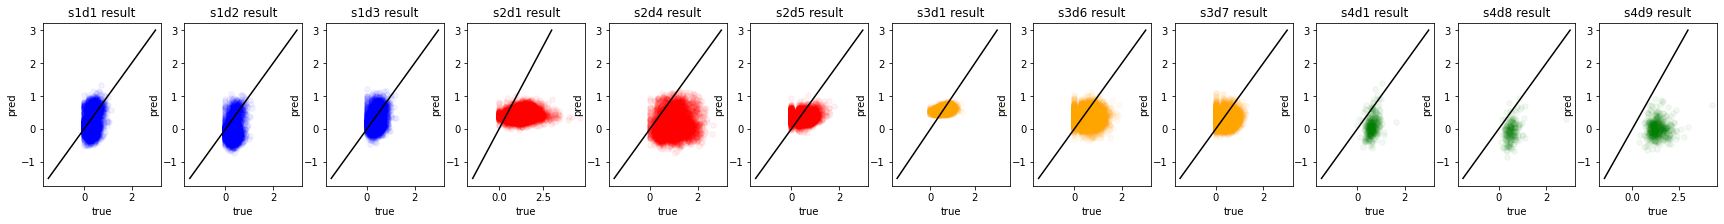

Epoch  2100 s1d1:  0.33647978 s1d2:  0.44182095 s1d3:  0.28435662 s2d1: 0.9252908 s2d4: 0.9514226 s2d5: 0.31479403 s3d1: 0.18804148 s3d6: 0.39319643 s3d7: 0.28961676 s4d1: 0.5932697 s4d8: 0.6702672 s4d9: 1.4176744 test loss: 1.0644494223714003
Epoch  2200 s1d1:  0.33531085 s1d2:  0.44012967 s1d3:  0.28339887 s2d1: 0.92379963 s2d4: 0.9497558 s2d5: 0.3145399 s3d1: 0.18780465 s3d6: 0.39226705 s3d7: 0.2892826 s4d1: 0.59101254 s4d8: 0.66829616 s4d9: 1.4150816 test loss: 1.062187542046964
Epoch  2300 s1d1:  0.333773 s1d2:  0.43786755 s1d3:  0.28212515 s2d1: 0.9225262 s2d4: 0.9479017 s2d5: 0.31435436 s3d1: 0.18757325 s3d6: 0.39130735 s3d7: 0.2889673 s4d1: 0.58838886 s4d8: 0.66581506 s4d9: 1.411984 test loss: 1.0594829407139257
Epoch  2400 s1d1:  0.33257964 s1d2:  0.4360866 s1d3:  0.28121647 s2d1: 0.92121166 s2d4: 0.94632846 s2d5: 0.31420827 s3d1: 0.18734029 s3d6: 0.3904823 s3d7: 0.2887274 s4d1: 0.5863565 s4d8: 0.66392756 s4d9: 1.4095526 test loss: 1.0573732895640569
Epoch  2500 s1d1:  0.33129

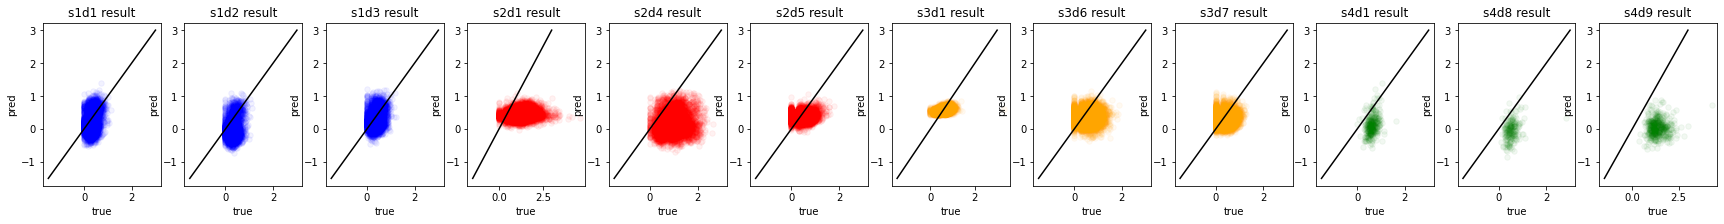

Epoch  3100 s1d1:  0.32590762 s1d2:  0.4251806 s1d3:  0.2760435 s2d1: 0.91429746 s2d4: 0.9368778 s2d5: 0.31408495 s3d1: 0.18580528 s3d6: 0.38590774 s3d7: 0.28810495 s4d1: 0.5731379 s4d8: 0.65102124 s4d9: 1.3926057 test loss: 1.0428849777410558
Epoch  3200 s1d1:  0.32552826 s1d2:  0.42443568 s1d3:  0.27583197 s2d1: 0.9134446 s2d4: 0.9359931 s2d5: 0.31409192 s3d1: 0.18559127 s3d6: 0.3854509 s3d7: 0.28810692 s4d1: 0.5720722 s4d8: 0.6500309 s4d9: 1.3911284 test loss: 1.0416559977589064
Epoch  3300 s1d1:  0.32506981 s1d2:  0.42382902 s1d3:  0.27548513 s2d1: 0.91286546 s2d4: 0.9353605 s2d5: 0.3141146 s3d1: 0.1853829 s3d6: 0.38503325 s3d7: 0.28810227 s4d1: 0.5711336 s4d8: 0.649222 s4d9: 1.3898679 test loss: 1.0406066876023055
Epoch  3400 s1d1:  0.32459894 s1d2:  0.4230771 s1d3:  0.27514246 s2d1: 0.91202927 s2d4: 0.9344612 s2d5: 0.314177 s3d1: 0.18516614 s3d6: 0.3845656 s3d7: 0.28814313 s4d1: 0.5699806 s4d8: 0.6481379 s4d9: 1.3882713 test loss: 1.039276570590131
Epoch  3500 s1d1:  0.32416195 s

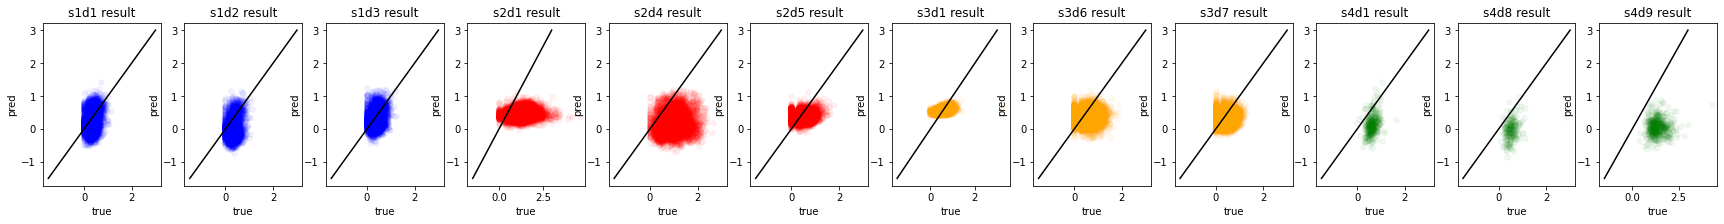

Epoch  4100 s1d1:  0.32218024 s1d2:  0.41779393 s1d3:  0.2738019 s2d1: 0.9087139 s2d4: 0.92856383 s2d5: 0.31526664 s3d1: 0.18364787 s3d6: 0.38238734 s3d7: 0.28914177 s4d1: 0.5621057 s4d8: 0.6399223 s4d9: 1.3765708 test loss: 1.0296013557132784
Epoch  4200 s1d1:  0.32198492 s1d2:  0.41736603 s1d3:  0.2736708 s2d1: 0.9083112 s2d4: 0.9279488 s2d5: 0.31546596 s3d1: 0.18342437 s3d6: 0.38214603 s3d7: 0.28935513 s4d1: 0.56129766 s4d8: 0.639137 s4d9: 1.3752351 test loss: 1.0285332765958832
Epoch  4300 s1d1:  0.32182482 s1d2:  0.41702616 s1d3:  0.27361614 s2d1: 0.90793735 s2d4: 0.92739195 s2d5: 0.31566018 s3d1: 0.18319833 s3d6: 0.38191122 s3d7: 0.2895456 s4d1: 0.56051683 s4d8: 0.63833845 s4d9: 1.374017 test loss: 1.0275407062336823
Epoch  4400 s1d1:  0.32176343 s1d2:  0.41684273 s1d3:  0.27361208 s2d1: 0.9074914 s2d4: 0.92687476 s2d5: 0.315856 s3d1: 0.18297032 s3d6: 0.38170242 s3d7: 0.28977656 s4d1: 0.5600232 s4d8: 0.63786876 s4d9: 1.3730363 test loss: 1.0267884216622385
Epoch  4500 s1d1:  0.32

In [34]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s3d1, pro_s3d1)

Epoch  0 s1d1:  0.3025379 s1d2:  0.31090447 s1d3:  0.2878648 s2d1: 1.1442189 s2d4: 0.9463033 s2d5: 0.4335602 s3d1: 0.49825355 s3d6: 0.507023 s3d7: 0.38204235 s4d1: 0.5614151 s4d8: 0.53141075 s4d9: 1.319053 test loss: 0.9809909350705975


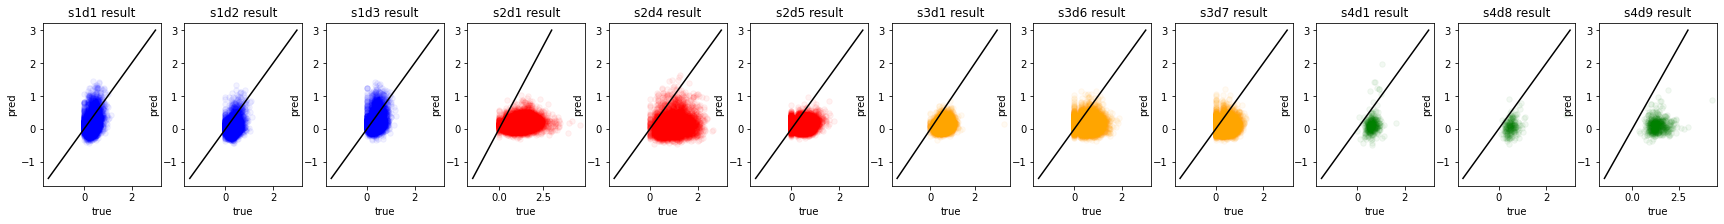

Epoch  100 s1d1:  0.24468409 s1d2:  0.2238876 s1d3:  0.24837624 s2d1: 0.90991104 s2d4: 0.6707028 s2d5: 0.31008962 s3d1: 0.26970032 s3d6: 0.31549552 s3d7: 0.2807971 s4d1: 0.2698027 s4d8: 0.2862894 s4d9: 1.0044202 test loss: 0.7101730510037796
Epoch  200 s1d1:  0.24316737 s1d2:  0.22283886 s1d3:  0.24825415 s2d1: 0.89423734 s2d4: 0.66207737 s2d5: 0.30973673 s3d1: 0.24177752 s3d6: 0.30770138 s3d7: 0.28252733 s4d1: 0.25844544 s4d8: 0.28366664 s4d9: 1.0048263 test loss: 0.7088067796079583
Epoch  300 s1d1:  0.24545424 s1d2:  0.22505155 s1d3:  0.25040492 s2d1: 0.8842698 s2d4: 0.653951 s2d5: 0.30983803 s3d1: 0.2290371 s3d6: 0.3030518 s3d7: 0.28429404 s4d1: 0.24924369 s4d8: 0.28019175 s4d9: 0.99977183 test loss: 0.7041239192392018
Epoch  400 s1d1:  0.24836992 s1d2:  0.2284507 s1d3:  0.2527524 s2d1: 0.8778501 s2d4: 0.6473032 s2d5: 0.31014693 s3d1: 0.22242385 s3d6: 0.29987183 s3d7: 0.28597787 s4d1: 0.24227807 s4d8: 0.2772896 s4d9: 0.99420476 test loss: 0.6994403879377278
Epoch  500 s1d1:  0.25193

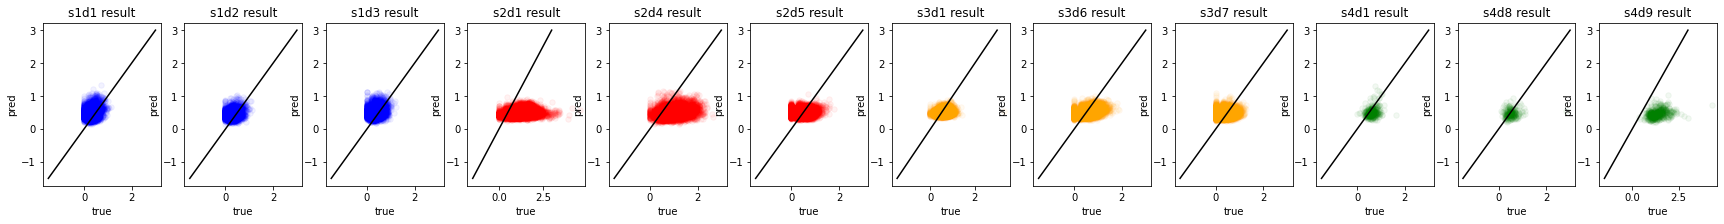

Epoch  1100 s1d1:  0.26856 s1d2:  0.24737942 s1d3:  0.26842117 s2d1: 0.8572833 s2d4: 0.6244955 s2d5: 0.31335315 s3d1: 0.20884672 s3d6: 0.28987983 s3d7: 0.29477757 s4d1: 0.22361687 s4d8: 0.26936492 s4d9: 0.9742945 test loss: 0.6836859895654794
Epoch  1200 s1d1:  0.27080905 s1d2:  0.24907035 s1d3:  0.27045107 s2d1: 0.8558037 s2d4: 0.6230407 s2d5: 0.31382045 s3d1: 0.20836583 s3d6: 0.28900027 s3d7: 0.2958055 s4d1: 0.22315711 s4d8: 0.26916543 s4d9: 0.9736212 test loss: 0.6831791047169856
Epoch  1300 s1d1:  0.27219105 s1d2:  0.25038233 s1d3:  0.27175465 s2d1: 0.85479695 s2d4: 0.6222307 s2d5: 0.31432474 s3d1: 0.20805131 s3d6: 0.28815952 s3d7: 0.29661933 s4d1: 0.22296405 s4d8: 0.269117 s4d9: 0.97352165 test loss: 0.6830890008933288
Epoch  1400 s1d1:  0.27370685 s1d2:  0.25163126 s1d3:  0.27325767 s2d1: 0.85377425 s2d4: 0.62154937 s2d5: 0.3148924 s3d1: 0.20779398 s3d6: 0.28734645 s3d7: 0.29740712 s4d1: 0.22294362 s4d8: 0.26902285 s4d9: 0.9734414 test loss: 0.6830266076867983
Epoch  1500 s1d1:  

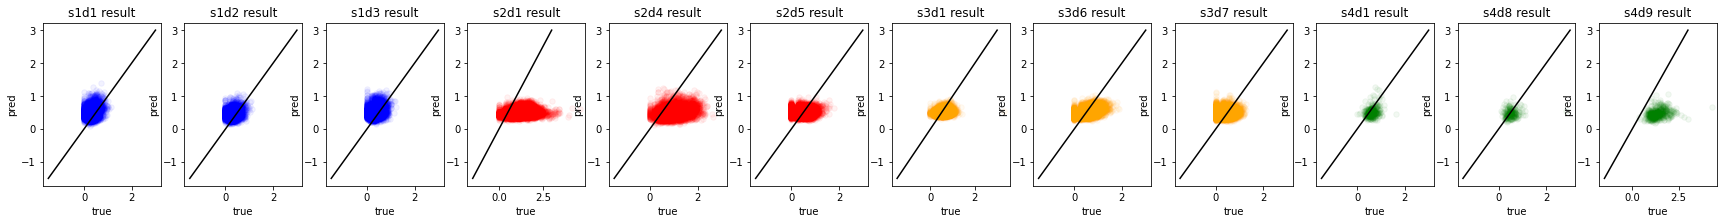

Epoch  2100 s1d1:  0.28143755 s1d2:  0.25865492 s1d3:  0.2808841 s2d1: 0.84924227 s2d4: 0.6185699 s2d5: 0.3182159 s3d1: 0.20801808 s3d6: 0.28184077 s3d7: 0.3025394 s4d1: 0.22455305 s4d8: 0.27010232 s4d9: 0.9740191 test loss: 0.683668603106797
Epoch  2200 s1d1:  0.28234318 s1d2:  0.2594937 s1d3:  0.28186646 s2d1: 0.8489057 s2d4: 0.6184447 s2d5: 0.3186294 s3d1: 0.20817867 s3d6: 0.281048 s3d7: 0.30315414 s4d1: 0.22508176 s4d8: 0.27031043 s4d9: 0.97437286 test loss: 0.6839749896910451
Epoch  2300 s1d1:  0.28333965 s1d2:  0.26042268 s1d3:  0.2829052 s2d1: 0.8484773 s2d4: 0.618208 s2d5: 0.31907165 s3d1: 0.20839031 s3d6: 0.28024408 s3d7: 0.30387855 s4d1: 0.22556478 s4d8: 0.27062142 s4d9: 0.97459173 test loss: 0.6841966926711236
Epoch  2400 s1d1:  0.284343 s1d2:  0.2612944 s1d3:  0.28388652 s2d1: 0.84817326 s2d4: 0.6180194 s2d5: 0.31950262 s3d1: 0.20860273 s3d6: 0.2794411 s3d7: 0.30456293 s4d1: 0.2260384 s4d8: 0.2708404 s4d9: 0.9747207 test loss: 0.6843511497901051
Epoch  2500 s1d1:  0.2852942

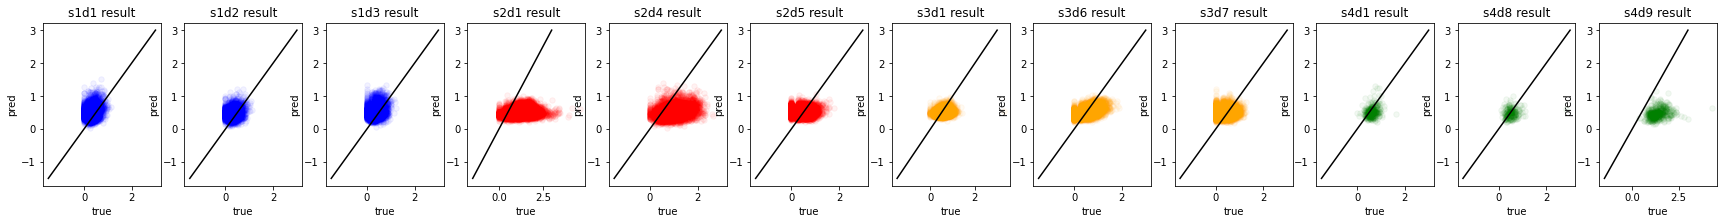

Epoch  3100 s1d1:  0.29330912 s1d2:  0.26918942 s1d3:  0.29285094 s2d1: 0.8465796 s2d4: 0.61555505 s2d5: 0.32233298 s3d1: 0.21093278 s3d6: 0.27359155 s3d7: 0.309448 s4d1: 0.22951743 s4d8: 0.2724336 s4d9: 0.97232914 test loss: 0.6833064375606877
Epoch  3200 s1d1:  0.29435652 s1d2:  0.27040464 s1d3:  0.293872 s2d1: 0.8463934 s2d4: 0.6153493 s2d5: 0.32286206 s3d1: 0.21141529 s3d6: 0.272731 s3d7: 0.3101622 s4d1: 0.22996515 s4d8: 0.27262986 s4d9: 0.97167635 test loss: 0.6829465942011645
Epoch  3300 s1d1:  0.29591742 s1d2:  0.27151453 s1d3:  0.29519463 s2d1: 0.84635305 s2d4: 0.61500007 s2d5: 0.3230897 s3d1: 0.2119162 s3d6: 0.27186406 s3d7: 0.31075144 s4d1: 0.2306794 s4d8: 0.27288973 s4d9: 0.9713868 test loss: 0.6828594650935977
Epoch  3400 s1d1:  0.29738683 s1d2:  0.27265778 s1d3:  0.29667327 s2d1: 0.8459973 s2d4: 0.61467344 s2d5: 0.32348764 s3d1: 0.21232557 s3d6: 0.27099055 s3d7: 0.31142202 s4d1: 0.23130615 s4d8: 0.27304468 s4d9: 0.9707974 test loss: 0.6825583112045158
Epoch  3500 s1d1:  0.

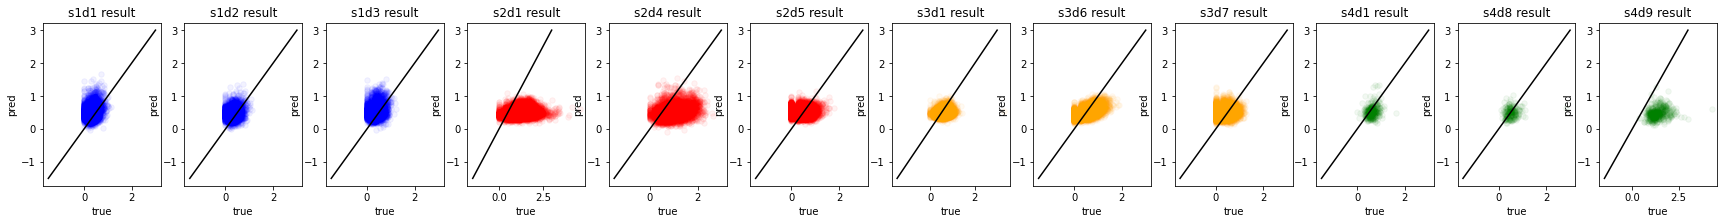

Epoch  4100 s1d1:  0.3080029 s1d2:  0.28094727 s1d3:  0.3064085 s2d1: 0.8443045 s2d4: 0.6128437 s2d5: 0.3262263 s3d1: 0.21590982 s3d6: 0.2646698 s3d7: 0.31684256 s4d1: 0.23668961 s4d8: 0.2752507 s4d9: 0.96639794 test loss: 0.6804894065185223
Epoch  4200 s1d1:  0.3091989 s1d2:  0.2819007 s1d3:  0.30742338 s2d1: 0.84389436 s2d4: 0.61272264 s2d5: 0.32667997 s3d1: 0.21640849 s3d6: 0.26373586 s3d7: 0.31753325 s4d1: 0.23747642 s4d8: 0.2756871 s4d9: 0.965499 test loss: 0.6800316624652657
Epoch  4300 s1d1:  0.3104141 s1d2:  0.28279397 s1d3:  0.30848914 s2d1: 0.84354264 s2d4: 0.61254114 s2d5: 0.32707688 s3d1: 0.21685883 s3d6: 0.26279536 s3d7: 0.3183809 s4d1: 0.23838656 s4d8: 0.27621952 s4d9: 0.9648744 test loss: 0.6797757980498246
Epoch  4400 s1d1:  0.31147107 s1d2:  0.28338414 s1d3:  0.3094447 s2d1: 0.8433107 s2d4: 0.61262393 s2d5: 0.32739964 s3d1: 0.21737541 s3d6: 0.2618499 s3d7: 0.31901821 s4d1: 0.23947003 s4d8: 0.27667734 s4d9: 0.9646981 test loss: 0.6798266677117498
Epoch  4500 s1d1:  0.31

In [35]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s3d6, pro_s3d6)

Epoch  0 s1d1:  0.30315185 s1d2:  0.31187025 s1d3:  0.28910646 s2d1: 1.1456065 s2d4: 0.9478266 s2d5: 0.43382716 s3d1: 0.4987527 s3d6: 0.5084224 s3d7: 0.38143253 s4d1: 0.5638006 s4d8: 0.53344536 s4d9: 1.3224351 test loss: 0.9837625859181308


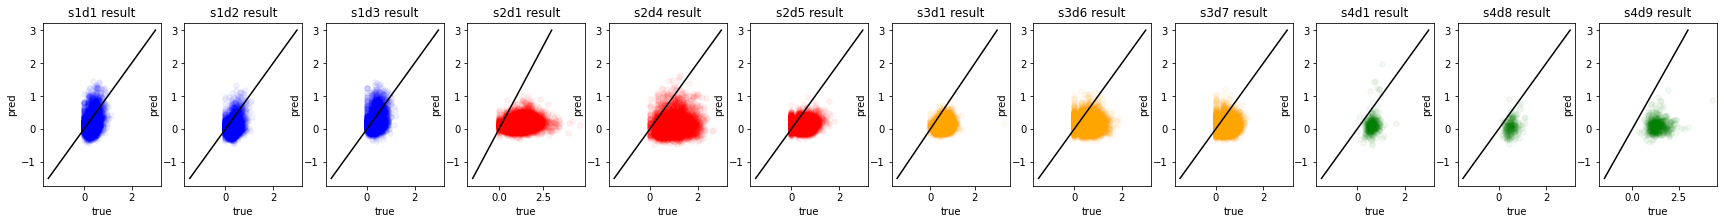

Epoch  100 s1d1:  0.21803023 s1d2:  0.20519689 s1d3:  0.2284629 s2d1: 1.0369718 s2d4: 0.7793766 s2d5: 0.3257845 s3d1: 0.37372237 s3d6: 0.37289095 s3d7: 0.25954735 s4d1: 0.37532923 s4d8: 0.33437836 s4d9: 1.1352835 test loss: 0.8135025269072949
Epoch  200 s1d1:  0.21058398 s1d2:  0.19990246 s1d3:  0.22213523 s2d1: 1.0314742 s2d4: 0.77428335 s2d5: 0.32013837 s3d1: 0.35643196 s3d6: 0.36842632 s3d7: 0.2542376 s4d1: 0.366306 s4d8: 0.32786608 s4d9: 1.1271957 test loss: 0.8063867292284754
Epoch  300 s1d1:  0.20573422 s1d2:  0.19651148 s1d3:  0.21775188 s2d1: 1.0271671 s2d4: 0.77102906 s2d5: 0.31654698 s3d1: 0.34534353 s3d6: 0.36570346 s3d7: 0.25094447 s4d1: 0.3589396 s4d8: 0.3229731 s4d9: 1.1210467 test loss: 0.8009185315271865
Epoch  400 s1d1:  0.20239408 s1d2:  0.19409882 s1d3:  0.21456069 s2d1: 1.0236616 s2d4: 0.7687422 s2d5: 0.31414628 s3d1: 0.337674 s3d6: 0.3638345 s3d7: 0.24859789 s4d1: 0.35345587 s4d8: 0.31939325 s4d9: 1.1162901 test loss: 0.7967464985693856
Epoch  500 s1d1:  0.19982967

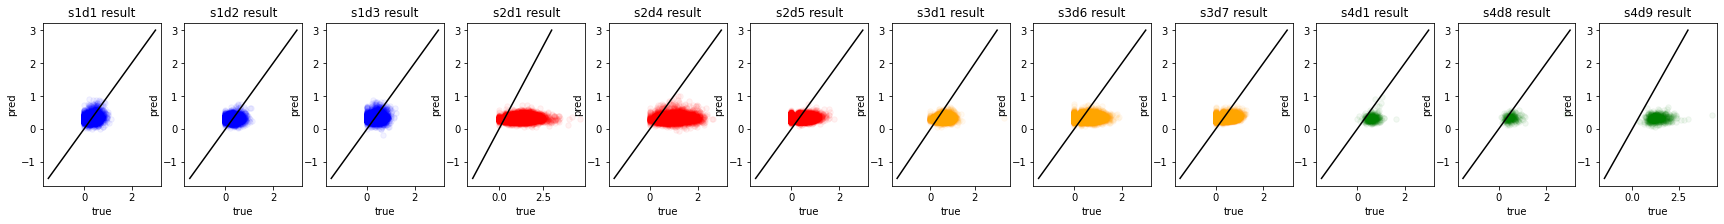

Epoch  1100 s1d1:  0.19299108 s1d2:  0.18712296 s1d3:  0.20442261 s2d1: 1.0126214 s2d4: 0.76555187 s2d5: 0.30777836 s3d1: 0.31230605 s3d6: 0.3589213 s3d7: 0.24112199 s4d1: 0.34295833 s4d8: 0.31334916 s4d9: 1.1084621 test loss: 0.7896695343386633
Epoch  1200 s1d1:  0.19269457 s1d2:  0.18682104 s1d3:  0.20408203 s2d1: 1.0117754 s2d4: 0.7657835 s2d5: 0.30743024 s3d1: 0.31069353 s3d6: 0.358658 s3d7: 0.24055046 s4d1: 0.34309945 s4d8: 0.3136852 s4d9: 1.1086192 test loss: 0.789818846760881
Epoch  1300 s1d1:  0.1925867 s1d2:  0.18675278 s1d3:  0.20398569 s2d1: 1.0111918 s2d4: 0.766125 s2d5: 0.30717275 s3d1: 0.30946937 s3d6: 0.35843793 s3d7: 0.2400275 s4d1: 0.34335366 s4d8: 0.3140723 s4d9: 1.1087682 test loss: 0.7899835913414379
Epoch  1400 s1d1:  0.19241577 s1d2:  0.18653215 s1d3:  0.20376234 s2d1: 1.0105644 s2d4: 0.76634127 s2d5: 0.30695957 s3d1: 0.3082097 s3d6: 0.35830578 s3d7: 0.23953678 s4d1: 0.34384587 s4d8: 0.31459063 s4d9: 1.109233 test loss: 0.790397174893281
Epoch  1500 s1d1:  0.19244

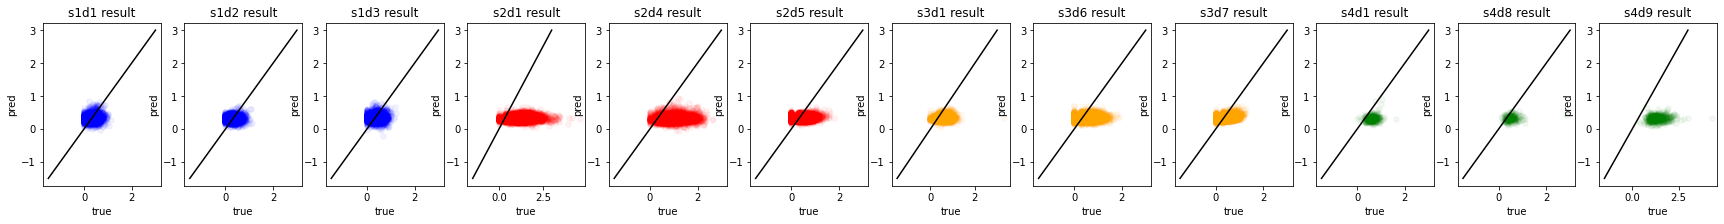

Epoch  2100 s1d1:  0.19366507 s1d2:  0.18735439 s1d3:  0.20502895 s2d1: 1.0084873 s2d4: 0.7706114 s2d5: 0.30649745 s3d1: 0.30302984 s3d6: 0.35820827 s3d7: 0.23652874 s4d1: 0.34952632 s4d8: 0.31941473 s4d9: 1.1136622 test loss: 0.794478101129548
Epoch  2200 s1d1:  0.1941776 s1d2:  0.18774278 s1d3:  0.20553067 s2d1: 1.0082053 s2d4: 0.7712279 s2d5: 0.30650735 s3d1: 0.30256802 s3d6: 0.35820273 s3d7: 0.23611508 s4d1: 0.35032544 s4d8: 0.32000947 s4d9: 1.1140382 test loss: 0.7948870420626943
Epoch  2300 s1d1:  0.19457522 s1d2:  0.18804418 s1d3:  0.20594849 s2d1: 1.0080587 s2d4: 0.7719849 s2d5: 0.30654696 s3d1: 0.30222896 s3d6: 0.35827503 s3d7: 0.23569825 s4d1: 0.35144505 s4d8: 0.32087806 s4d9: 1.1148945 test loss: 0.7956752747365559
Epoch  2400 s1d1:  0.19510098 s1d2:  0.18843648 s1d3:  0.2064642 s2d1: 1.0078762 s2d4: 0.7725958 s2d5: 0.30659693 s3d1: 0.3019611 s3d6: 0.358293 s3d7: 0.23527716 s4d1: 0.35231185 s4d8: 0.32153016 s4d9: 1.1153344 test loss: 0.796140610829028
Epoch  2500 s1d1:  0.19

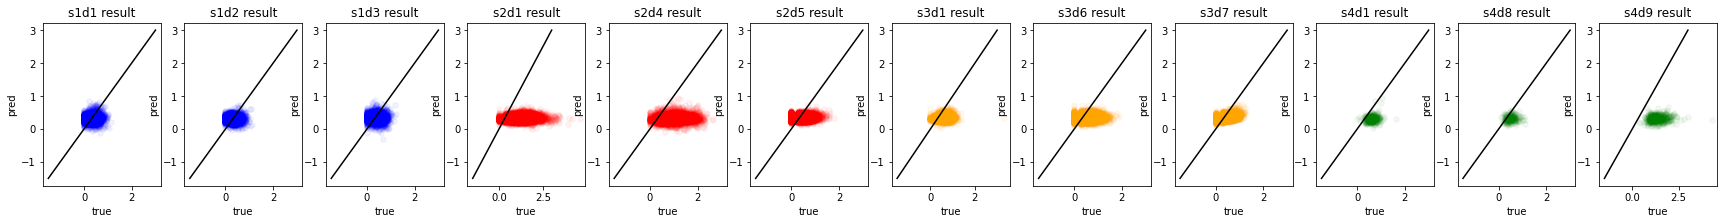

Epoch  3100 s1d1:  0.19963723 s1d2:  0.19204094 s1d3:  0.21114594 s2d1: 1.0076711 s2d4: 0.7777399 s2d5: 0.30757028 s3d1: 0.30195844 s3d6: 0.35923517 s3d7: 0.23219652 s4d1: 0.36008424 s4d8: 0.32699093 s4d9: 1.1197151 test loss: 0.8005725691824603
Epoch  3200 s1d1:  0.20040838 s1d2:  0.19265215 s1d3:  0.21193022 s2d1: 1.007618 s2d4: 0.7782739 s2d5: 0.3077502 s3d1: 0.30213445 s3d6: 0.3593751 s3d7: 0.23173144 s4d1: 0.36101165 s4d8: 0.32764938 s4d9: 1.1200434 test loss: 0.8009784820038781
Epoch  3300 s1d1:  0.20108992 s1d2:  0.1932499 s1d3:  0.21266279 s2d1: 1.0076733 s2d4: 0.77890337 s2d5: 0.307949 s3d1: 0.30234924 s3d6: 0.35957465 s3d7: 0.23126355 s4d1: 0.36205828 s4d8: 0.3283665 s4d9: 1.1205996 test loss: 0.8015539537405499
Epoch  3400 s1d1:  0.20194395 s1d2:  0.19395459 s1d3:  0.21355249 s2d1: 1.0077637 s2d4: 0.77955896 s2d5: 0.3081607 s3d1: 0.30273306 s3d6: 0.35977533 s3d7: 0.23078951 s4d1: 0.36299276 s4d8: 0.32900822 s4d9: 1.1208956 test loss: 0.8019394736979217
Epoch  3500 s1d1:  0.2

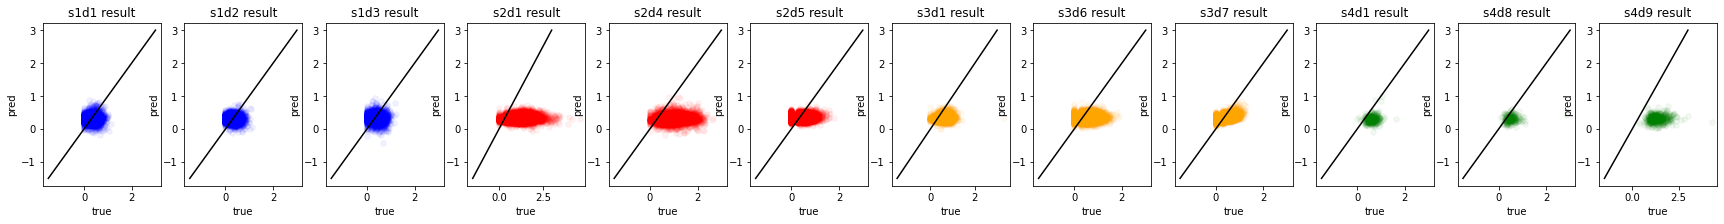

Epoch  4100 s1d1:  0.20787215 s1d2:  0.19893701 s1d3:  0.21981853 s2d1: 1.0084077 s2d4: 0.78391874 s2d5: 0.3097745 s3d1: 0.3047297 s3d6: 0.36144033 s3d7: 0.22729105 s4d1: 0.37041438 s4d8: 0.33415058 s4d9: 1.1239874 test loss: 0.8054915317593668
Epoch  4200 s1d1:  0.20873131 s1d2:  0.19965214 s1d3:  0.22076325 s2d1: 1.0085945 s2d4: 0.78462446 s2d5: 0.3100772 s3d1: 0.305076 s3d6: 0.3617819 s3d7: 0.22677292 s4d1: 0.3716461 s4d8: 0.33494586 s4d9: 1.1245695 test loss: 0.8061220949390951
Epoch  4300 s1d1:  0.20955454 s1d2:  0.20038077 s1d3:  0.22166605 s2d1: 1.0087329 s2d4: 0.7852376 s2d5: 0.31033942 s3d1: 0.305347 s3d6: 0.3620946 s3d7: 0.22624944 s4d1: 0.3728303 s4d8: 0.33569288 s4d9: 1.1251547 test loss: 0.8067436299864201
Epoch  4400 s1d1:  0.21044567 s1d2:  0.20113651 s1d3:  0.22261143 s2d1: 1.0087909 s2d4: 0.7855103 s2d5: 0.31061807 s3d1: 0.30589572 s3d6: 0.36236066 s3d7: 0.22572103 s4d1: 0.37353048 s4d8: 0.33609343 s4d9: 1.1251339 test loss: 0.806872956574746
Epoch  4500 s1d1:  0.21142

In [36]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s3d7, pro_s3d7)